# Import Libraries

In [1]:
import os
import math
import warnings
from IPython.display import clear_output 

# data manipulation and analysis
import numpy as np
import pandas as pd
from pandas import DataFrame
from pandas import concat
from numpy import arange

# data visualisation
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px

# statistical analysis
import scipy.stats as stats

# ML and model evaluation
from sklearn.preprocessing import PowerTransformer
from sklearn.compose import ColumnTransformer
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.linear_model import Lasso
from sklearn.model_selection import TimeSeriesSplit, GridSearchCV

# statistical modeling
import statsmodels.api as sm
import statsmodels.formula.api as smf
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.linear_model import LassoCV
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.ensemble import RandomForestRegressor
from sklearn.utils import resample

# ignore warnings
warnings.simplefilter(action='ignore')  # this is for libraries that have changes occuring and some functions will be unsupported in the future

#print(os.getcwd())  # find dir for file paths

# Data Preparation and Cleaning

## Load data and Initial Inspection
- import data
- check columns names and types
- do initial removal of obvious irrelevant rows and columns
- Calculations for LIQ

In [2]:
# load data from csv or excel files 

LTIdf = pd.read_csv("../Data/For Python/LTI/ltiHistorical.csv")
INFdf = pd.read_csv("../Data/For Python/CPI/cpiHistoricalForecasts.csv")
# filter to maintain only CPI data
INFdf = INFdf[INFdf['Inflation'].isin(['CPI forecast', 'CPI outturn'])]

# FDI  
FDIdfall = pd.read_csv("../Data/For Python/FDI/fdiData.csv", skiprows=4)
FDIdfall.columns = FDIdfall.columns.str.replace('"', '').str.strip()
FDIdf = FDIdfall[FDIdfall['Country Name'] == 'United Kingdom']
    # Keep only the year columns and their values
FDIdf = FDIdf.iloc[:, 4:]  # Remove "Country Name", "Country Code", and "Indicator Name" columns
FDIdf = FDIdf.dropna(axis=1, how='all')
FDIdf = FDIdf.reset_index(drop=True)
    # transpose the data
FDIdf = FDIdf.T
FDIdf = FDIdf.reset_index()
FDIdf.columns = ['Year', 'FDI'] 

# GDP
GDPdf = pd.read_excel("../Data/For Python/GDP/gdpHistoricalForecast.xlsx", sheet_name="Data", skiprows=4)
GDPdf = GDPdf.dropna(axis=1, how='all') 
GDPdf.columns = ["Year", "GDP", "Unit"]

# UNPL 
UNPLdf = pd.read_excel("../Data/For Python/UNPL/londonUnemployment.xlsx", sheet_name="Data", skiprows=4)
UNPLdf = UNPLdf.dropna(axis=1, how='all') 
UNPLdf.columns = ["Year", "Unemployment", "Unit"]


# CoStar 
costar_path = "../Data/For Python/CoStar/costarData.xlsx"

if os.path.exists(costar_path):
    costar_xls = pd.ExcelFile(costar_path)

    # extract sheets
    NIYdf = costar_xls.parse("London Yield")
    london_industrial_df = costar_xls.parse("London Industrial Data")

    # extract columns
    LIQdf = london_industrial_df[["Period", "Market Asking Rent Index", "Market Sale Price Index"]].copy()
    # calculate LIQ - subtract directly as both scaled relative to 2008 Q4
    LIQdf.loc[:, "LIQ"] = LIQdf["Market Asking Rent Index"] - LIQdf["Market Sale Price Index"]
    RENTGdf = london_industrial_df[["Period", "Market Asking Rent Growth"]]
    NETABdf = london_industrial_df[["Period", "Net Absorption Sq ft"]]
    VACRdf = london_industrial_df[["Period", "Vacancy Rate"]]
else:
    print(f"Error: {costar_path} not found!")

In [3]:
# function to print DFs
def print_dfs():
    dataframes = {
    "LTI": LTIdf,
    "INF": INFdf,
    "FDI": FDIdf,
    "GDP": GDPdf,
    "UNPL": UNPLdf,
    "NIY": NIYdf,
    "LIQ": LIQdf,
    "RENTG": RENTGdf,
    "NETAB": NETABdf,
    "VACR": VACRdf
}
    for name, df in dataframes.items():
        print(f"===== {name} Data =====")
        print(df.head(), "\n")

# call function to verify imports 
#print_dfs()

## Cleaning and Preprocessing each df
- Check missing values in each df
- Align frequencies
- Standardise date format (YYYY-QX)
- Further removal of irrelevant columns and renaming


In [4]:
# checking for missing values in each dataset
dataframes = {
    "LTI": LTIdf,
    "INF": INFdf,
    "FDI": FDIdf,
    "GDP": GDPdf,
    "Unemployment": UNPLdf,
    "NIY": NIYdf,
    "LIQ": LIQdf,
    "RENTG": RENTGdf,
    "NETAB": NETABdf,
    "VACR": VACRdf
}

for name, df in dataframes.items():
    missing_values = df.isnull().sum()
    if missing_values.any():  
        print(f"===== Missing Values in {name} Data =====")
        print(missing_values[missing_values > 0])  # only print columns with missing values
        print("\n")

In [5]:
# GDP from annual to quarterly assuming GDP remained constant across quarters
def process_gdp_data(GDPdf):
    """_summary_: converts annual GDP to quarterly values

    Args:
        GDPdf (df): original df for GDP

    Raises:
        ValueError: if not containing expected columns

    Returns:
        df: df with quarterly GDP values 
    """
    if not all(col in GDPdf.columns for col in ['Year', 'GDP', 'Unit']):
            raise ValueError("DataFrame must contain 'Year', 'GDP', and 'Unit' columns.") # ensure columns are correct
    GDPdf['Year'] = GDPdf['Year'].astype(str).str.replace('*', '') # clean * from future values 
    
    # create quarterly data
    quarterly_data = []
    for index, row in GDPdf.iterrows():
        year = row['Year']
        gdp = row['GDP']
        unit = row['Unit']

        # check if 'year' is numerical
        try:
            year_int = int(year)
        except ValueError:
            print(f"Skipping row with non-numerical year: {year}")
            continue

        for quarter in range(1, 5):
            quarterly_data.append({
                'Year': year,
                'Quarter': quarter,
                'GDP': gdp,
                'Unit': unit
            })
    quarterly_df = pd.DataFrame(quarterly_data)
    quarterly_df['Year'] = quarterly_df['Year'].astype(int)
    return quarterly_df

# process GDP data
try:
    quarterly_gdp_df = process_gdp_data(GDPdf)
    print("Quarterly GDP data created successfully.")
except ValueError as e:
    print(f"Error processing GDP data: {e}")
except Exception as e:
    print(f"An unexpected error occurred: {e}")
    
GDPdf = quarterly_gdp_df

Quarterly GDP data created successfully.


In [6]:
# FDI from annual to quarterly assuming constant across quarters
def process_fdi_data(FDIdf):
    """_summary_: converts annual FDI to quarterly values

    Args:
        FDIdf (df): original df for FDI

    Raises:
        ValueError: if not containing expected columns

    Returns:
        df: df with quarterly FDI values 
    """
    if not all(col in FDIdf.columns for col in ['Year', 'FDI']):
            raise ValueError("DataFrame must contain 'Year' and 'FDI' columns.") # ensure columns are correct
    FDIdf['Year'] = FDIdf['Year'].astype(str)  # ensure the 'Year' column is a string
    
    # create quarterly data
    quarterly_data = []
    for index, row in FDIdf.iterrows():
        year = row['Year']
        fdi = row['FDI']

        # check if 'year' is numerical
        try:
            year_int = int(year)
        except ValueError:
            print(f"Skipping row with non-numerical year: {year}")
            continue

        for quarter in range(1, 5):
            quarterly_data.append({
                'Year': year,
                'Quarter': quarter,
                'FDI': fdi
            })
    quarterly_df = pd.DataFrame(quarterly_data)
    quarterly_df['Year'] = quarterly_df['Year'].astype(int)
    return quarterly_df

# process FDI data
try:
    quarterly_fdi_df = process_fdi_data(FDIdf)
    print("Quarterly FDI data created successfully.")
except ValueError as e:
    print(f"Error processing FDI data: {e}")
except Exception as e:
    print(f"An unexpected error occurred: {e}")
    
FDIdf = quarterly_fdi_df

Quarterly FDI data created successfully.


In [7]:
# align dates of all dfs to YYYY-QX format
def standardise_date_format(df, date_column_name, current_format, df_name=""):
    """_summary_: creating a standardised date column in each df 

    Args:
        df (df): each variable's df
        date_column_name (str): name of the original date column
        current_format (str): how is the original date formatted?
        df_name (str, optional): name of the df. Defaults to "".

    Returns:
        df: returns df with the new column
    """
    try:
        df = df.copy()
        if current_format == "YYYY-MM-DD":
            df[date_column_name] = pd.to_datetime(df[date_column_name])
            df["Year"] = df[date_column_name].dt.year
            df["Quarter"] = df[date_column_name].dt.quarter
            df['Date_Std'] = df["Year"].astype(str) + "-Q" + df["Quarter"].astype(str)
            df.drop(columns=["Year", "Quarter"], inplace=True)
            return df

        elif current_format == "YYYYQX":
            df["Year"] = df[date_column_name].str[:4].astype(int)
            df["Quarter"] = df[date_column_name].str[4:].str.replace("Q", "").astype(int)
            df['Date_Std'] = df["Year"].astype(str) + "-Q" + df["Quarter"].astype(str)
            df.drop(columns=["Year", "Quarter"], inplace=True)
            return df

        elif current_format == "YYYY QX":
            df["Year"] = df[date_column_name].str.split(" ").str[0].astype(int)
            df["Quarter"] = df[date_column_name].str.split(" ").str[1].str.replace("Q", "").astype(int)
            df['Date_Std'] = df["Year"].astype(str) + "-Q" + df["Quarter"].astype(str)
            df.drop(columns=["Year", "Quarter"], inplace=True)
            return df

        elif current_format == "QX YYYY":
            df["Year"] = df[date_column_name].str.split(" ").str[1].astype(int)
            df["Quarter"] = df[date_column_name].str.split(" ").str[0].str.replace("Q", "").astype(int)
            df['Date_Std'] = df["Year"].astype(str) + "-Q" + df["Quarter"].astype(str)
            df.drop(columns=["Year", "Quarter"], inplace=True)
            return df

        else:
            print(f"WARNING: Date Format '{current_format}' not supported for {df_name}. Returning df unchanged.")
            return df
    except Exception as e:
        print(f"ERROR: Issue converting {df_name} to new format. Returning df unchanged. Error: {e}")
        return df

# GDP & FDI (already in "Year" and "Quarter" format)
GDPdf['Date_Std'] = GDPdf['Year'].astype(str) + '-Q' + GDPdf['Quarter'].astype(str)
FDIdf['Date_Std'] = FDIdf['Year'].astype(str) + '-Q' + FDIdf['Quarter'].astype(str)

# fix UNPL data
UNPLdf["Year"] = UNPLdf["Year"].astype(str)
UNPLdf["Year_Extracted"] = UNPLdf["Year"].str.split(" ").str[1].astype(int)  
UNPLdf["Quarter_Extracted"] = UNPLdf["Year"].str.split(" ").str[0].str.replace("Q", "").astype(int)  
UNPLdf["Date_Std"] = UNPLdf["Year_Extracted"].astype(str) + "-Q" + UNPLdf["Quarter_Extracted"].astype(str)

# the rest
LTIdf   = standardise_date_format(LTIdf, "observation_date", "YYYY-MM-DD", "LTI")
INFdf   = standardise_date_format(INFdf, "Quarter", "YYYYQX", "INF")
VACRdf  = standardise_date_format(VACRdf, "Period", "YYYY QX", "VACR")
NETABdf = standardise_date_format(NETABdf, "Period", "YYYY QX", "NETAB")
RENTGdf = standardise_date_format(RENTGdf, "Period", "YYYY QX", "RENTG")
LIQdf   = standardise_date_format(LIQdf, "Period", "YYYY QX", "LIQ")
NIYdf   = standardise_date_format(NIYdf, "Period", "YYYY QX", "NIY")

# verify output
#print_dfs()


In [8]:
# remove irrelevant columns and rename anything (cleaner, easier to work with)
UNPLdf.drop(columns=[col for col in ['Unit', 'Year_Extracted', 'Quarter_Extracted'] if col in UNPLdf.columns], inplace=True)
LIQdf.drop(columns=[col for col in ['Market Asking Rent Index', 'Market Sale Price Index'] if col in LIQdf.columns], inplace=True)

if 'Inflation' in INFdf.columns:
    INFdf.drop(columns=['Inflation'], inplace=True)

if 'observation_date' in LTIdf.columns:
    LTIdf.drop(columns=['observation_date'], inplace=True)
if 'IRLTLT01GBQ156N' in LTIdf.columns:
    LTIdf.rename(columns={"IRLTLT01GBQ156N": "LTI"}, inplace=True)

if 'Updated Cap Rate - Average between Costar and CBRE' in NIYdf.columns:
    NIYdf.rename(columns={"Updated Cap Rate - Average between Costar and CBRE": "NIY"}, inplace=True)

if 'Value' in INFdf.columns:
    INFdf.rename(columns={"Value": "INF"}, inplace=True)
    
if 'Unemployment' in UNPLdf.columns:
    UNPLdf.rename(columns={'Unemployment': 'UNPL'}, inplace=True)
    
if 'Market Asking Rent Growth' in RENTGdf.columns:
    RENTGdf.rename(columns={'Market Asking Rent Growth': 'RENTG'}, inplace=True)
    
if 'Vacancy Rate' in VACRdf.columns:
    VACRdf.rename(columns={'Vacancy Rate': 'VACR'}, inplace=True)

if 'Net Absorption Sq ft' in NETABdf.columns:
    NETABdf.rename(columns={'Net Absorption Sq ft': 'NETAB'}, inplace=True)

if 'Unit' in GDPdf.columns:
    GDPdf.drop(columns=['Unit'], inplace=True)
    
for df in [FDIdf, GDPdf]:
    if 'Quarter' in df.columns:
        df.drop(columns=['Quarter'], inplace=True)
    
    
for df in [NIYdf, LIQdf, RENTGdf, NETABdf, VACRdf]:
    if 'Period' in df.columns:
        df.drop(columns=['Period'], inplace=True)


for df in [FDIdf, GDPdf, UNPLdf]:
    if 'Year' in df.columns:
        df.drop(columns=['Year'], inplace=True)

# verify output
#print_dfs()

## Merge dataframes

In [9]:
# set date to datetime format
for df in [LTIdf, INFdf, FDIdf, GDPdf, UNPLdf, NIYdf, LIQdf, RENTGdf, NETABdf, VACRdf]:
    df['Date_Std'] = pd.PeriodIndex(df['Date_Std'], freq='Q').to_timestamp()
    #print(df.tail()) # to check


In [10]:
# filter LTI because memory issues when merging and it goes back to 1960
LTIdf = LTIdf[LTIdf['Date_Std'] >= '2000-01-01'].copy()
#print(LTIdf.head())

# same for FDI
FDIdf = FDIdf[FDIdf['Date_Std'] >= '2000-01-01'].copy()
#print(FDIdf.head())

# and INF
INFdf = INFdf[INFdf['Date_Std'] >= '2000-01-01'].copy()
#print(INFdf.head())

In [11]:
for df in [LTIdf, INFdf, FDIdf, GDPdf, UNPLdf, NIYdf, LIQdf, RENTGdf, NETABdf, VACRdf]:
    df['Date_Std'] = pd.to_datetime(df['Date_Std'], format='%Y-%m-%d', errors='coerce')  # convert to datetime format
    # print(df.head()) # to check
    for col in df.select_dtypes(include=['float64', 'int64']).columns:
        df[col] = pd.to_numeric(df[col], downcast='float')
        
# outer merge so no data is dropped at this stage

df_final = LTIdf.merge(INFdf, on='Date_Std', how='outer', sort=False)
df_final = df_final.merge(FDIdf, on='Date_Std', how='outer', sort=False)


df_final = df_final.merge(GDPdf, on='Date_Std', how='outer', sort=False)


df_final = df_final.merge(UNPLdf, on='Date_Std', how='outer', sort=False)


df_final = df_final.merge(NIYdf, on='Date_Std', how='outer', sort=False)
df_final = df_final.merge(LIQdf, on='Date_Std', how='outer', sort=False)


df_final = df_final.merge(RENTGdf, on='Date_Std', how='outer', sort=False)
df_final = df_final.merge(NETABdf, on='Date_Std', how='outer', sort=False)


df_final = df_final.merge(VACRdf, on='Date_Std', how='outer', sort=False)

df_final.sort_values(by='Date_Std', inplace=True)

# confirm merge
# print(df_final.head())
# print(df_final.tail())

## Overview

In [12]:
# look at entire dataset

pd.set_option('display.max_rows', None)  # ,None = show all rows
pd.set_option('display.max_columns', None)  # ,None = show all columns
pd.set_option('display.width', 1000)  # prevent line breaks
pd.set_option('display.colheader_justify', 'center')  
pd.set_option('display.float_format', '{:.2f}'.format)  

# df_final
# for less output
df_final.head(20)

,LTI,Date_Std,INF,FDI,GDP,UNPL,NIY,LIQ,RENTG,NETAB,VACR
0,5.61,2000-01-01,0.70,164130335444.12,3.70,7.60,NaN,NaN,NaN,NaN,NaN
1,5.31,2000-04-01,0.55,164130335444.12,3.70,7.30,NaN,NaN,NaN,NaN,NaN
2,5.32,2000-07-01,0.83,164130335444.12,3.70,6.90,NaN,NaN,NaN,NaN,NaN
3,5.08,2000-10-01,0.97,164130335444.12,3.70,6.80,NaN,NaN,NaN,NaN,NaN
4,4.79,2001-01-01,0.97,56090924808.79,2.10,6.50,NaN,NaN,NaN,NaN,NaN
5,5.09,2001-04-01,1.51,56090924808.79,2.10,6.20,NaN,NaN,NaN,NaN,NaN
6,5.06,2001-07-01,1.51,56090924808.79,2.10,6.60,NaN,NaN,NaN,NaN,NaN
7,4.78,2001-10-01,0.96,56090924808.79,2.10,7.30,NaN,NaN,NaN,NaN,NaN
8,5.02,2002-01-01,1.51,89760582753.22,2.10,6.90,NaN,NaN,NaN,NaN,NaN
9,5.20,2002-04-01,0.95,89760582753.22,2.10,6.80,NaN,NaN,NaN,NaN,NaN


In [13]:
# data overview (data types, non-null counts, null counts)

df_info = pd.DataFrame(df_final.dtypes, columns=['Data Type'])
df_info['Non-Null Count'] = df_final.notnull().sum()
df_info['Null Count'] = df_final.isnull().sum()
df_info['Null Percentage'] = (df_info['Null Count'] / len(df_final)) * 100  # missing value check 
df_info = df_info.sort_values(by='Non-Null Count', ascending=True)

# display 
df_info.style.set_table_attributes('class="table table-striped"').format({'Null Percentage': '{:.2f}%'})


,Data Type,Non-Null Count,Null Count,Null Percentage
NIY,float32,63,74,54.01%
LIQ,float32,77,60,43.80%
RENTG,float32,77,60,43.80%
NETAB,float32,77,60,43.80%
VACR,float32,77,60,43.80%
FDI,float64,96,41,29.93%
LTI,float32,116,21,15.33%
UNPL,float32,116,21,15.33%
GDP,float32,136,1,0.73%
Date_Std,datetime64[ns],137,0,0.00%


In [14]:
# select only numeric cols 
numeric_cols = df_final.select_dtypes(include='number').columns

## Deal with missing values/duplicates in merged df

In [15]:
# filter to 2014 q1 to 2023 q4
# keep the original data intact
df_final_copy = df_final.copy()  

# filter out rows where 'VACR' is missing - this is where all LDN CoStar data starts
vacr_filtered = df_final.dropna(subset=['VACR'])
fdi_filtered = df_final.dropna(subset=['FDI'])

start_date = vacr_filtered['Date_Std'].min()  # start of data
end_date = fdi_filtered['Date_Std'].max() # end of data

# filter the data based on 'Date_Std' 
df_filtered = df_final[
    (df_final['Date_Std'] >= start_date) & (df_final['Date_Std'] <= end_date)
]

# check
# df_filtered  # conclusion: data is missing due to mismatched timeframes across sources


In [16]:
# duplicates check
duplicates = df_filtered[df_filtered.duplicated()]
duplicates.style.set_table_attributes('class="table table-striped"')

,LTI,Date_Std,INF,FDI,GDP,UNPL,NIY,LIQ,RENTG,NETAB,VACR


In [17]:
# convert % to decimal 
    # what is % and not automatically converted by Python: LTI, INF, GDP, UNPL

percentage_cols = ['LTI', 'INF', 'GDP', 'UNPL']
df_filtered[percentage_cols] = df_filtered[percentage_cols] / 100

In [18]:
def descriptive_statistics():
    desc_stats = df_filtered[numeric_cols].describe().T  # transpose for formatting
    skewness = df_filtered[numeric_cols].skew()
    kurtosis = df_filtered[numeric_cols].kurtosis()
    desc_stats['skewness'] = skewness
    desc_stats['kurtosis'] = kurtosis
    desc_stats = desc_stats.round(2)
    styled_desc_stats = desc_stats.style.set_table_attributes('class="table table-striped"').highlight_max(axis=0, color='lightgreen').highlight_min(axis=0, color='lightcoral')
    return styled_desc_stats

descriptive_statistics = descriptive_statistics()
descriptive_statistics

,count,mean,std,min,25%,50%,75%,max,skewness,kurtosis
LTI,40.000000,0.020000,0.010000,0.000000,0.010000,0.010000,0.020000,0.040000,1.050000,0.470000
INF,40.000000,0.030000,0.030000,-0.000000,0.010000,0.020000,0.030000,0.110000,1.490000,1.200000
FDI,40.000000,66683158617.059998,110031571407.259995,-89439143375.020004,5055966700.850000,45115701261.360001,125358809934.119995,324813224213.020020,1.070000,1.000000
GDP,40.000000,0.020000,0.040000,-0.090000,0.020000,0.020000,0.030000,0.080000,-1.620000,3.030000
UNPL,40.000000,0.060000,0.010000,0.040000,0.050000,0.050000,0.060000,0.080000,0.620000,-0.400000
NIY,40.000000,0.040000,0.010000,0.030000,0.040000,0.050000,0.050000,0.050000,-0.000000,-1.350000
LIQ,40.000000,-106.560000,64.060000,-207.230000,-158.070000,-116.290000,-45.770000,-11.940000,-0.040000,-1.550000
RENTG,40.000000,0.020000,0.000000,0.010000,0.020000,0.020000,0.020000,0.020000,-0.260000,0.250000
NETAB,40.000000,-118007.770000,551672.190000,-1080133.000000,-506062.750000,-137933.500000,215749.000000,1279471.000000,0.400000,-0.170000
VACR,40.000000,0.040000,0.010000,0.020000,0.030000,0.040000,0.040000,0.050000,-0.390000,-0.400000


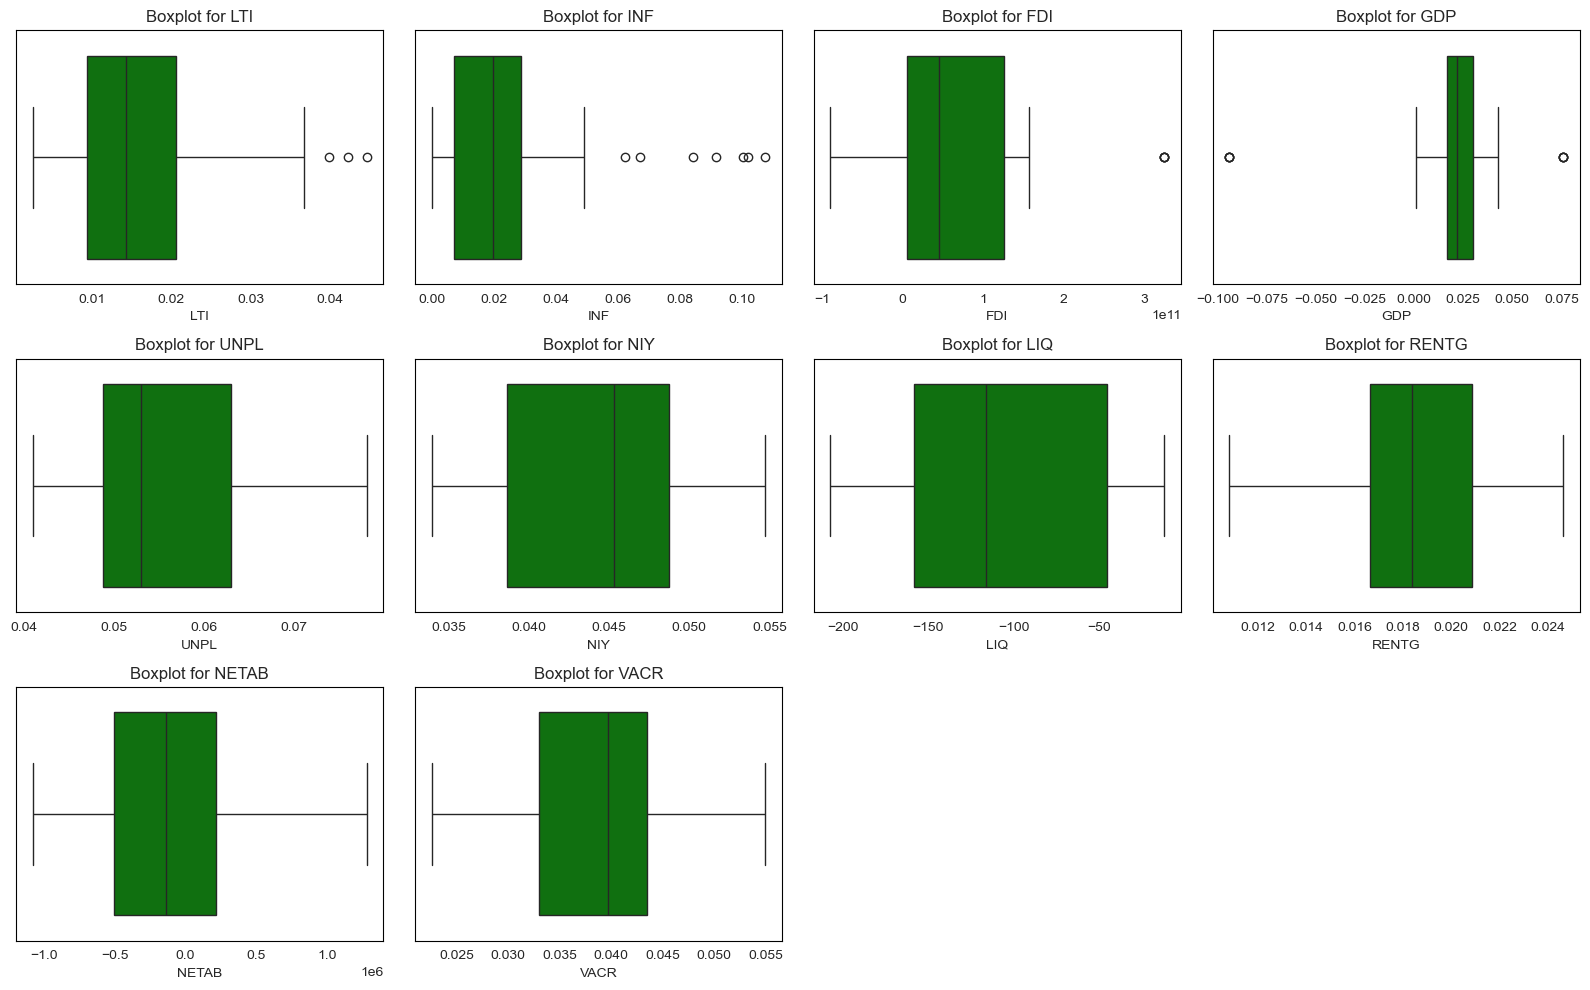

In [19]:
# outlier check and handling 

# check through boxplots first
sns.set_style("white", {'axes.edgecolor': 'black', 'grid.color': '0.9'})
plt.figure(figsize=(16, 10))

for i, col in enumerate(numeric_cols, 1):
    plt.subplot(3, 4, i) 
    sns.boxplot(data=df_filtered, x=col, color='green')
    plt.title(f'Boxplot for {col}')
    plt.tight_layout()

plt.show()

In [20]:
# use IQR to detect further
def detect_outliers_iqr(df, column):
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    
    # outliers are values outside bounds
    outliers = df[(df[column] < lower_bound) | (df[column] > upper_bound)]
    return outliers


outliers = {}

# apply function
for col in numeric_cols:
    outliers[col] = detect_outliers_iqr(df_filtered, col)


outlier_summary = pd.DataFrame({col: outliers[col].shape[0] for col in outliers}, index=['Number of Outliers'])
outlier_summary = outlier_summary.T 
styled_outlier_summary = outlier_summary.style.set_table_attributes('class="table table-striped"')
styled_outlier_summary


,Number of Outliers
LTI,3
INF,7
FDI,4
GDP,8
UNPL,0
NIY,0
LIQ,0
RENTG,0
NETAB,0
VACR,0


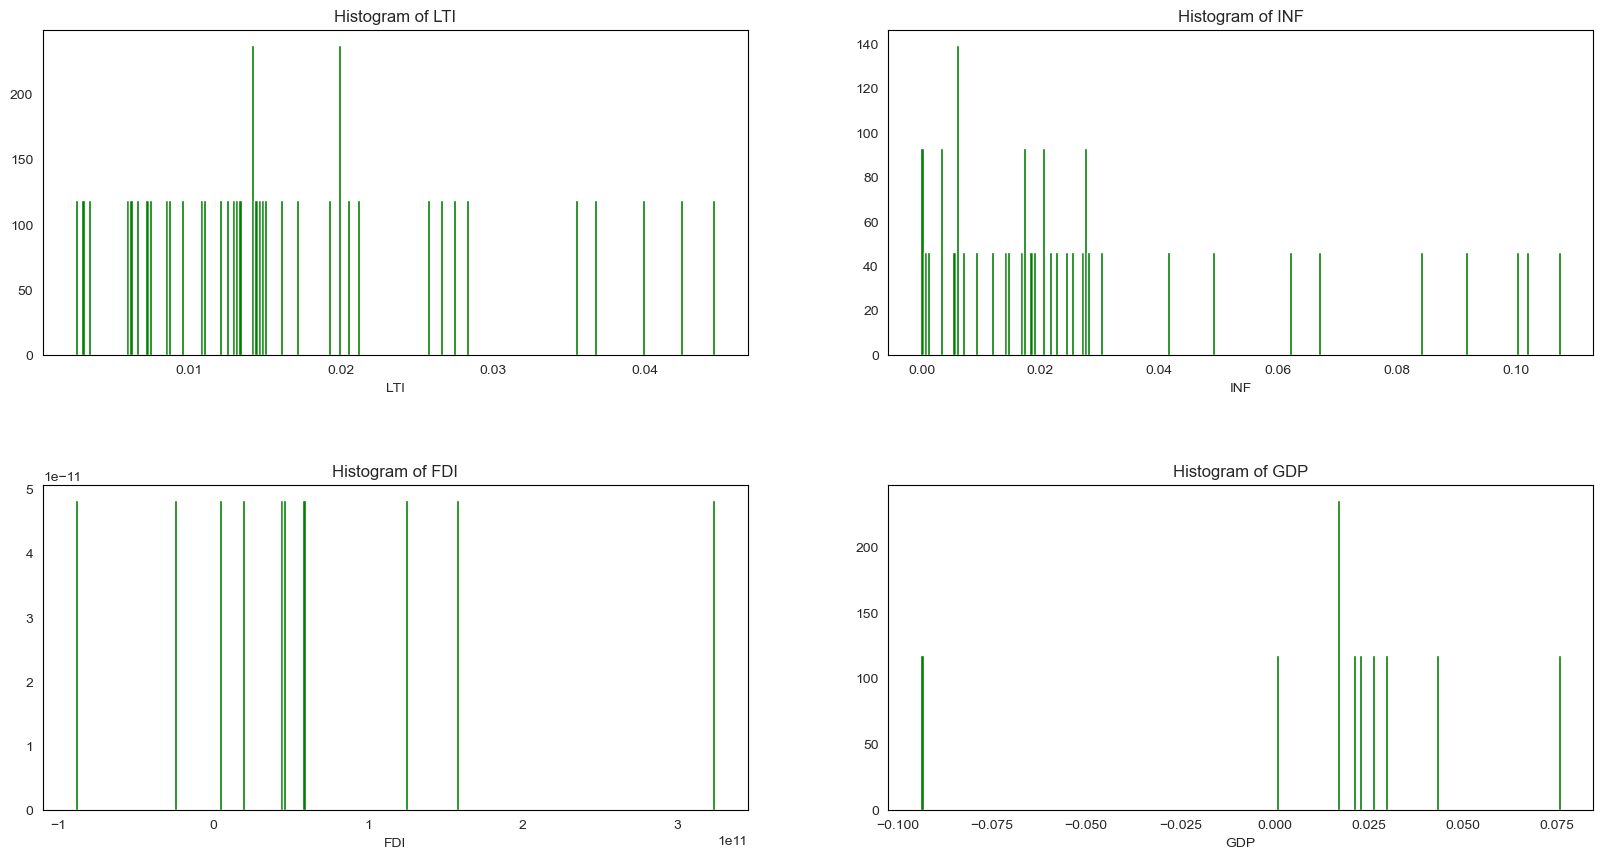

In [21]:
def print_outlier_plot():
    vars_with_outliers = ['LTI', 'INF', 'FDI', 'GDP']
    
    num_vars = len(vars_with_outliers) # dynamically create
    rows = (num_vars // 2) + (num_vars % 2) 
    
    fig, axes = plt.subplots(rows, 2, figsize=(20, 5 * rows))  
    axes = axes.flatten()  

    for i, column in enumerate(vars_with_outliers):
        axes[i].hist(df_filtered[column], bins=200, density=True, color='green')
        axes[i].set_xlabel(column)
        axes[i].set_title(f'Histogram of {column}') 
    
    for j in range(i + 1, len(axes)):
        fig.delaxes(axes[j])

    fig.subplots_adjust(hspace=0.4, bottom=0.1)
    plt.show()
    
    
print_outlier_plot()

In [22]:
# deal with outliers
# convert scientific notation to regular notation
pd.set_option('display.float_format', '{:,.6f}'.format)

In [23]:
# transform (needed for LASSO as well) - do separately to be able to inverse later
iv_cols = [col for col in numeric_cols if col != 'NIY']

iv_transformer = ColumnTransformer(
    [('power', PowerTransformer(method='yeo-johnson'), iv_cols)],
    remainder='passthrough'
)
df_filtered[iv_cols] = iv_transformer.fit_transform(df_filtered[iv_cols])

# Transform NIY separately (preserves time series properties)
y_transformer = PowerTransformer(method='yeo-johnson')
df_filtered['NIY'] = y_transformer.fit_transform(df_filtered[['NIY']])

In [24]:
# check outliers are handled 
outliers = {}

# apply function
for col in numeric_cols:
    outliers[col] = detect_outliers_iqr(df_filtered, col)


outlier_summary = pd.DataFrame({col: outliers[col].shape[0] for col in outliers}, index=['Number of Outliers'])
outlier_summary = outlier_summary.T 
styled_outlier_summary = outlier_summary.style.set_table_attributes('class="table table-striped"')
styled_outlier_summary

,Number of Outliers
LTI,0
INF,0
FDI,4
GDP,8
UNPL,0
NIY,0
LIQ,0
RENTG,0
NETAB,0
VACR,0


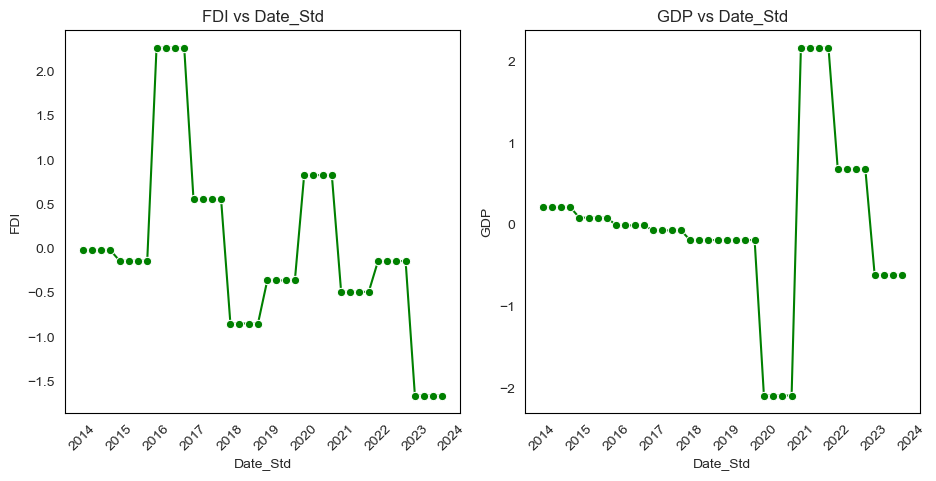

In [25]:
# investigate extreme values further
plt.figure(figsize=(14, 18))
outlier_cols = ['FDI', 'GDP']
for i, col in enumerate(outlier_cols, 1):
    plt.subplot(4, 3, i)
    
    sns.lineplot(data=df_filtered, x='Date_Std', y=col, marker='o', color='green')
    
    plt.title(f'{col} vs Date_Std')
    plt.xticks(rotation=45) 
    plt.tight_layout()

plt.show()

In [26]:
# brexit and covid dummys created due to the extreme values in the plots 
# referendum to official exit 
df_filtered['Brexit_Dummy'] = np.where(
    (df_filtered['Date_Std'] >= '2016-01-01') & (df_filtered['Date_Std'] <= '2020-01-01'), 1, 0
)

# restriction period
df_filtered['COVID_Dummy'] = np.where(
    (df_filtered['Date_Std'] >= '2020-01-01') & (df_filtered['Date_Std'] <= '2022-04-01'), 1, 0
)

In [27]:
# interaction terms
df_filtered['FDI_Brexit'] = df_filtered['FDI'] * df_filtered['Brexit_Dummy']
df_filtered['FDI_COVID'] = df_filtered['FDI'] * df_filtered['COVID_Dummy']
df_filtered['GDP_COVID'] = df_filtered['GDP'] * df_filtered['COVID_Dummy']

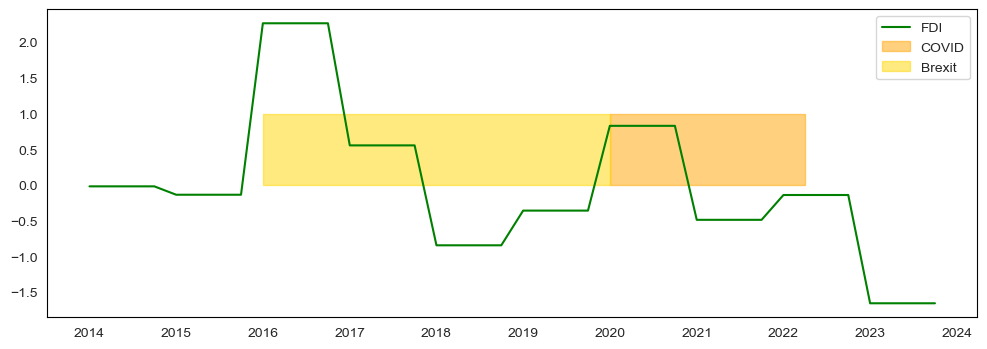

In [28]:
# plot FDI with COVID/Brexit shaded
plt.figure(figsize=(12,4))
plt.plot(df_filtered['Date_Std'], df_filtered['FDI'], label='FDI', color='green')
plt.fill_between(df_filtered['Date_Std'], 0, 1, 
                where=df_filtered['COVID_Dummy']==1, 
                color='orange', alpha=0.5, label='COVID')
plt.fill_between(df_filtered['Date_Std'], 0, 1, 
                where=df_filtered['Brexit_Dummy']==1, 
                color='gold', alpha=0.5, label='Brexit')
plt.legend()
plt.show()

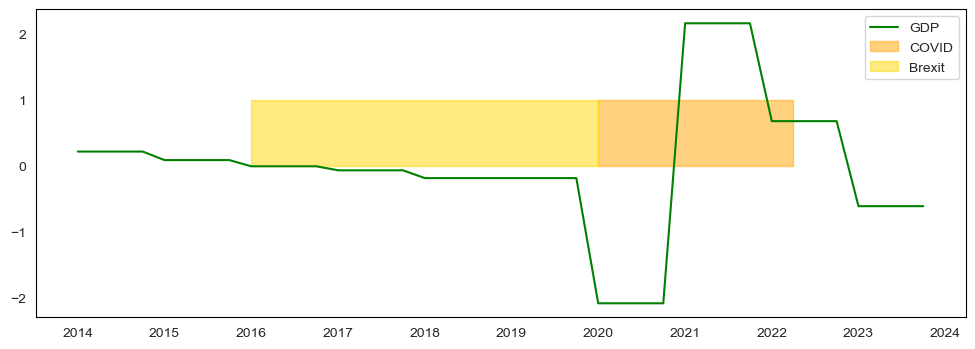

In [29]:
# plot GDP with COVID/Brexit shaded
plt.figure(figsize=(12,4))
plt.plot(df_filtered['Date_Std'], df_filtered['GDP'], label='GDP', color='green')
plt.fill_between(df_filtered['Date_Std'], 0, 1, 
                where=df_filtered['COVID_Dummy']==1, 
                color='orange', alpha=0.5, label='COVID')
plt.fill_between(df_filtered['Date_Std'], 0, 1, 
                where=df_filtered['Brexit_Dummy']==1, 
                color='gold', alpha=0.5, label='Brexit')
plt.legend()
plt.show()

In [30]:
fdi_stats = df_filtered[['FDI', 'FDI_COVID', 'FDI_Brexit']].describe().T
styled_fdi_stats = fdi_stats.style.set_table_attributes('class="table table-striped"')
styled_fdi_stats

,count,mean,std,min,25%,50%,75%,max
FDI,40.000000,-0.000000,1.012739,-1.658159,-0.488664,-0.138921,0.554652,2.265885
FDI_COVID,40.000000,0.026954,0.308518,-0.488664,-0.000000,-0.000000,0.000000,0.828610
FDI_Brexit,40.000000,0.182265,0.792632,-0.845633,0.000000,-0.000000,0.000000,2.265885


In [31]:
gdp_stats = df_filtered[['GDP', 'GDP_COVID']].describe().T
styled_gdp_stats = gdp_stats.style.set_table_attributes('class="table table-striped"')
styled_gdp_stats

,count,mean,std,min,25%,50%,75%,max
GDP,40.000000,-0.000000,1.012739,-2.086470,-0.186209,-0.037463,0.216872,2.164073
GDP_COVID,40.000000,0.041669,0.973978,-2.086470,-0.000000,-0.000000,0.000000,2.164073


# Exploratory Data Analysis (EDA)

In [32]:
# descriptive stats
def descriptive_statistics():
    desc_stats = df_filtered[numeric_cols].describe().T 
    skewness = df_filtered[numeric_cols].skew()
    kurtosis = df_filtered[numeric_cols].kurtosis()
    desc_stats['skewness'] = skewness
    desc_stats['kurtosis'] = kurtosis
    desc_stats = desc_stats.round(2)
    styled_desc_stats = desc_stats.style.set_table_attributes('class="table table-striped"').highlight_max(axis=0, color='lightgreen').highlight_min(axis=0, color='lightcoral')
    return styled_desc_stats

descriptive_statistics = descriptive_statistics()
descriptive_statistics

,count,mean,std,min,25%,50%,75%,max,skewness,kurtosis
LTI,40.000000,-0.000000,1.010000,-1.890000,-0.720000,-0.070000,0.570000,1.900000,0.140000,-0.600000
INF,40.000000,-0.000000,1.010000,-1.550000,-0.910000,-0.050000,0.400000,1.830000,0.340000,-0.770000
FDI,40.000000,-0.000000,1.010000,-1.660000,-0.490000,-0.140000,0.550000,2.270000,0.730000,0.740000
GDP,40.000000,-0.000000,1.010000,-2.090000,-0.190000,-0.040000,0.220000,2.160000,0.120000,1.440000
UNPL,40.000000,-0.000000,1.010000,-1.950000,-0.670000,-0.100000,0.950000,1.980000,0.120000,-1.000000
NIY,40.000000,-0.000000,1.010000,-1.670000,-0.900000,0.190000,0.760000,1.740000,-0.000000,-1.350000
LIQ,40.000000,0.000000,1.010000,-1.400000,-0.840000,-0.290000,0.910000,1.840000,0.210000,-1.470000
RENTG,40.000000,-0.000000,1.010000,-2.530000,-0.700000,-0.080000,0.850000,2.430000,-0.000000,0.010000
NETAB,40.000000,0.000000,1.010000,-1.890000,-0.710000,0.030000,0.660000,2.360000,0.150000,-0.420000
VACR,40.000000,-0.000000,1.010000,-1.820000,-0.700000,0.170000,0.710000,2.650000,-0.020000,-0.130000


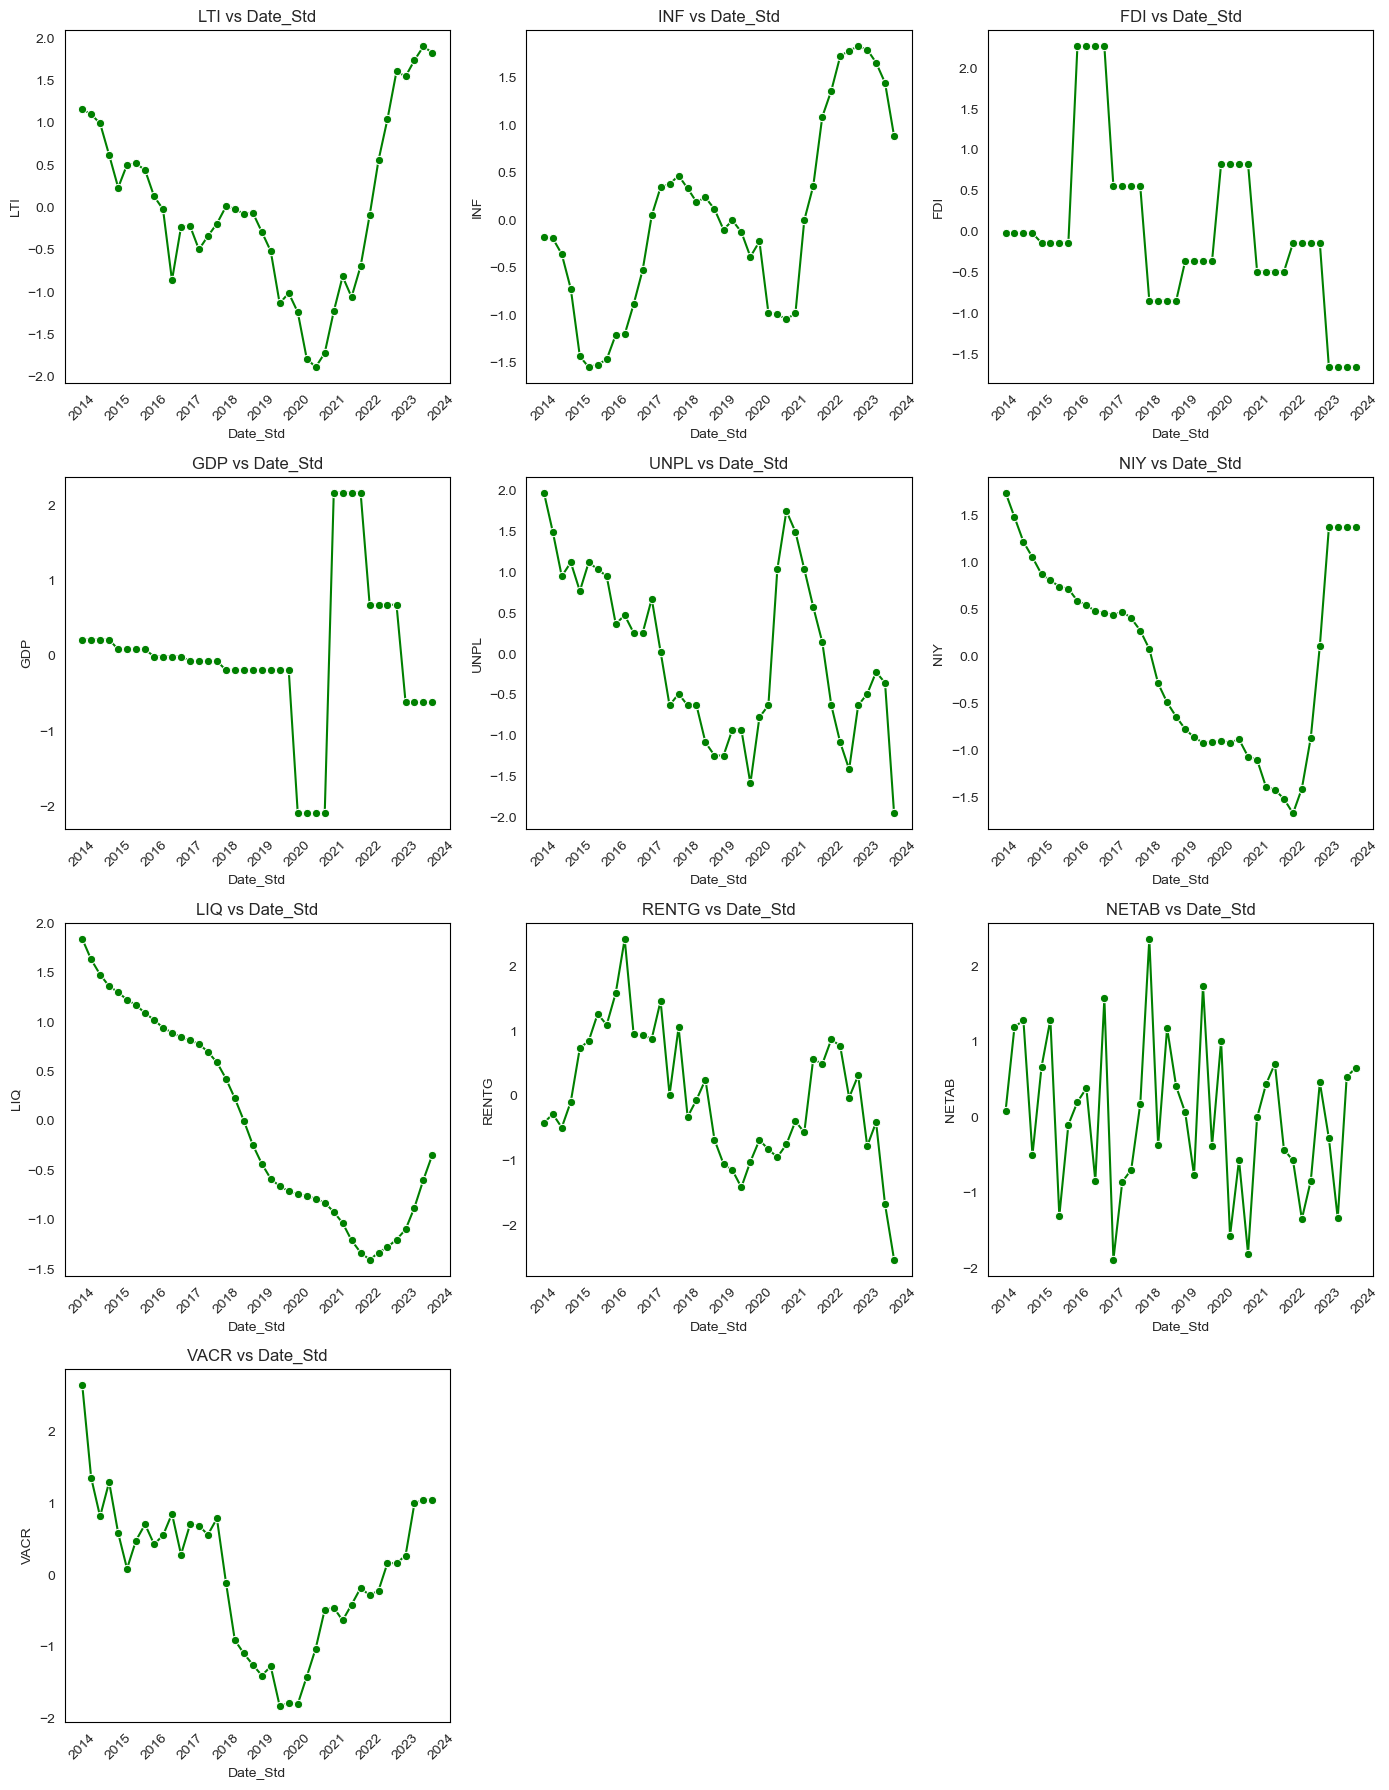

In [33]:
# plot each variable by itself
plt.figure(figsize=(14, 18))


for i, col in enumerate(numeric_cols, 1):
    plt.subplot(4, 3, i)
    
    # plot
    sns.lineplot(data=df_filtered, x='Date_Std', y=col, marker='o', color='green')
    
    plt.title(f'{col} vs Date_Std')
    plt.xticks(rotation=45)
    plt.tight_layout()

plt.show()

In [34]:
# note how covid and brexit impacted things ^
# investigate: 

<Figure size 2000x800 with 0 Axes>

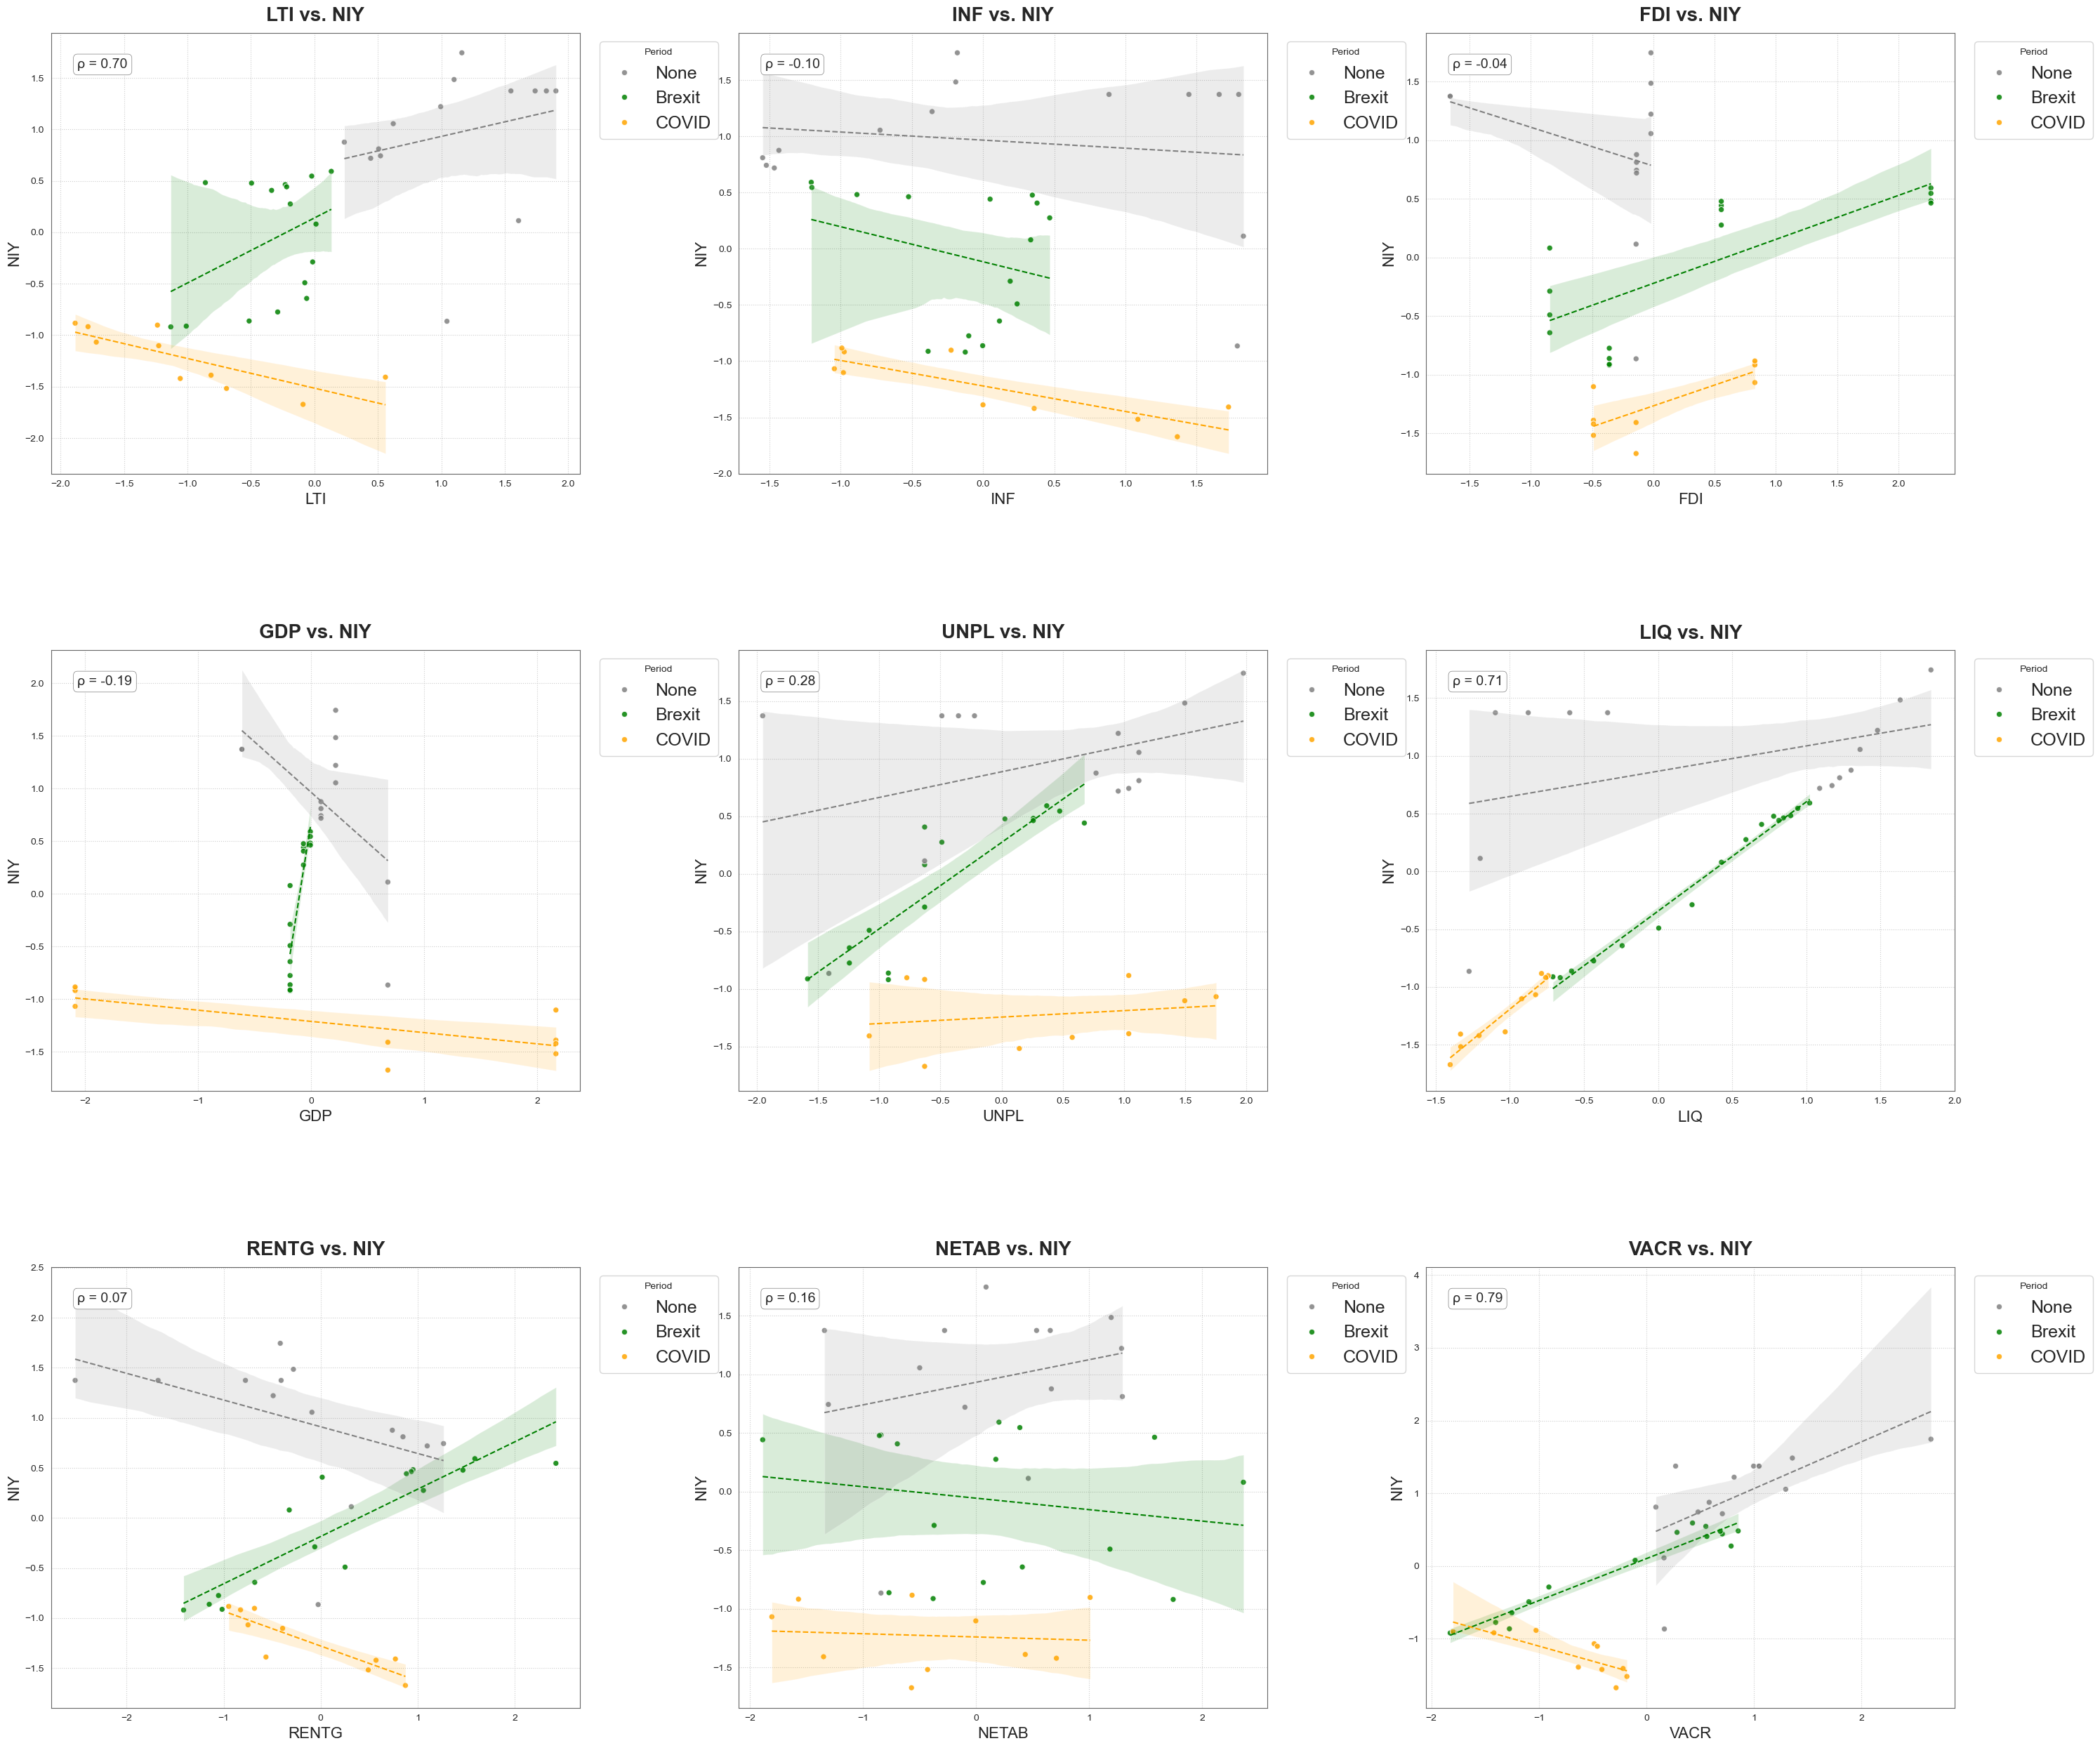

In [35]:
# plot interactions 

sns.set_style("whitegrid", {'grid.linestyle': ':', 'axes.edgecolor': '0.4'})
plt.figure(figsize=(20, 8))

# classify time periods - label data points based on date
df_filtered['Period'] = 'None'
df_filtered.loc[df_filtered['Brexit_Dummy'] == 1, 'Period'] = 'Brexit'
df_filtered.loc[df_filtered['COVID_Dummy'] == 1, 'Period'] = 'COVID'

palette = {'Brexit': 'green', 'COVID': 'orange', 'Both': 'blue', 'None': 'grey'}

variables = ['LTI', 'INF', 'FDI', 'GDP', 'UNPL', 'LIQ', 'RENTG', 'NETAB', 'VACR']

fig, axes = plt.subplots(3, 3, figsize=(30, 25))  
axes = axes.flatten()

sns.set_style("whitegrid")

for i, var in enumerate(variables):
    ax = axes[i]
    
    # scatter plot code: 
    sns.scatterplot(
        data=df_filtered,
        x=var,
        y='NIY',
        hue='Period',
        palette=palette,
        alpha=0.85,
        edgecolor='w',
        linewidth=0.8,
        ax=ax
    )
    
    # add regression lines to each period: 
    for period, colour in palette.items():
        sns.regplot(
            data=df_filtered[df_filtered['Period'] == period],
            x=var,
            y='NIY',
            scatter=False,
            color=colour,
            line_kws={'lw': 1.5, 'ls': '--'},
            ax=ax, 
        )
    
    # format
    ax.set_title(f'{var} vs. NIY', fontsize=20, pad=12, fontweight='semibold')
    ax.set_xlabel(var, fontsize=16)
    ax.set_ylabel('NIY', fontsize=16)
    ax.legend(title='Period', bbox_to_anchor=(1.02, 1), loc='upper left', fontsize=18)
    
    # coefficient
    corr = df_filtered[[var, 'NIY']].corr().iloc[0, 1]
    ax.annotate(f'ρ = {corr:.2f}', xy=(0.05, 0.92), 
                xycoords='axes fraction', fontsize=14,
                bbox=dict(boxstyle="round,pad=0.3", fc="white", ec="grey", lw=0.5))

for j in range(i+1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.subplots_adjust(wspace=0.3, hspace=0.4)
plt.show()

In [36]:
df_filtered = df_filtered.drop('Period', axis=1)

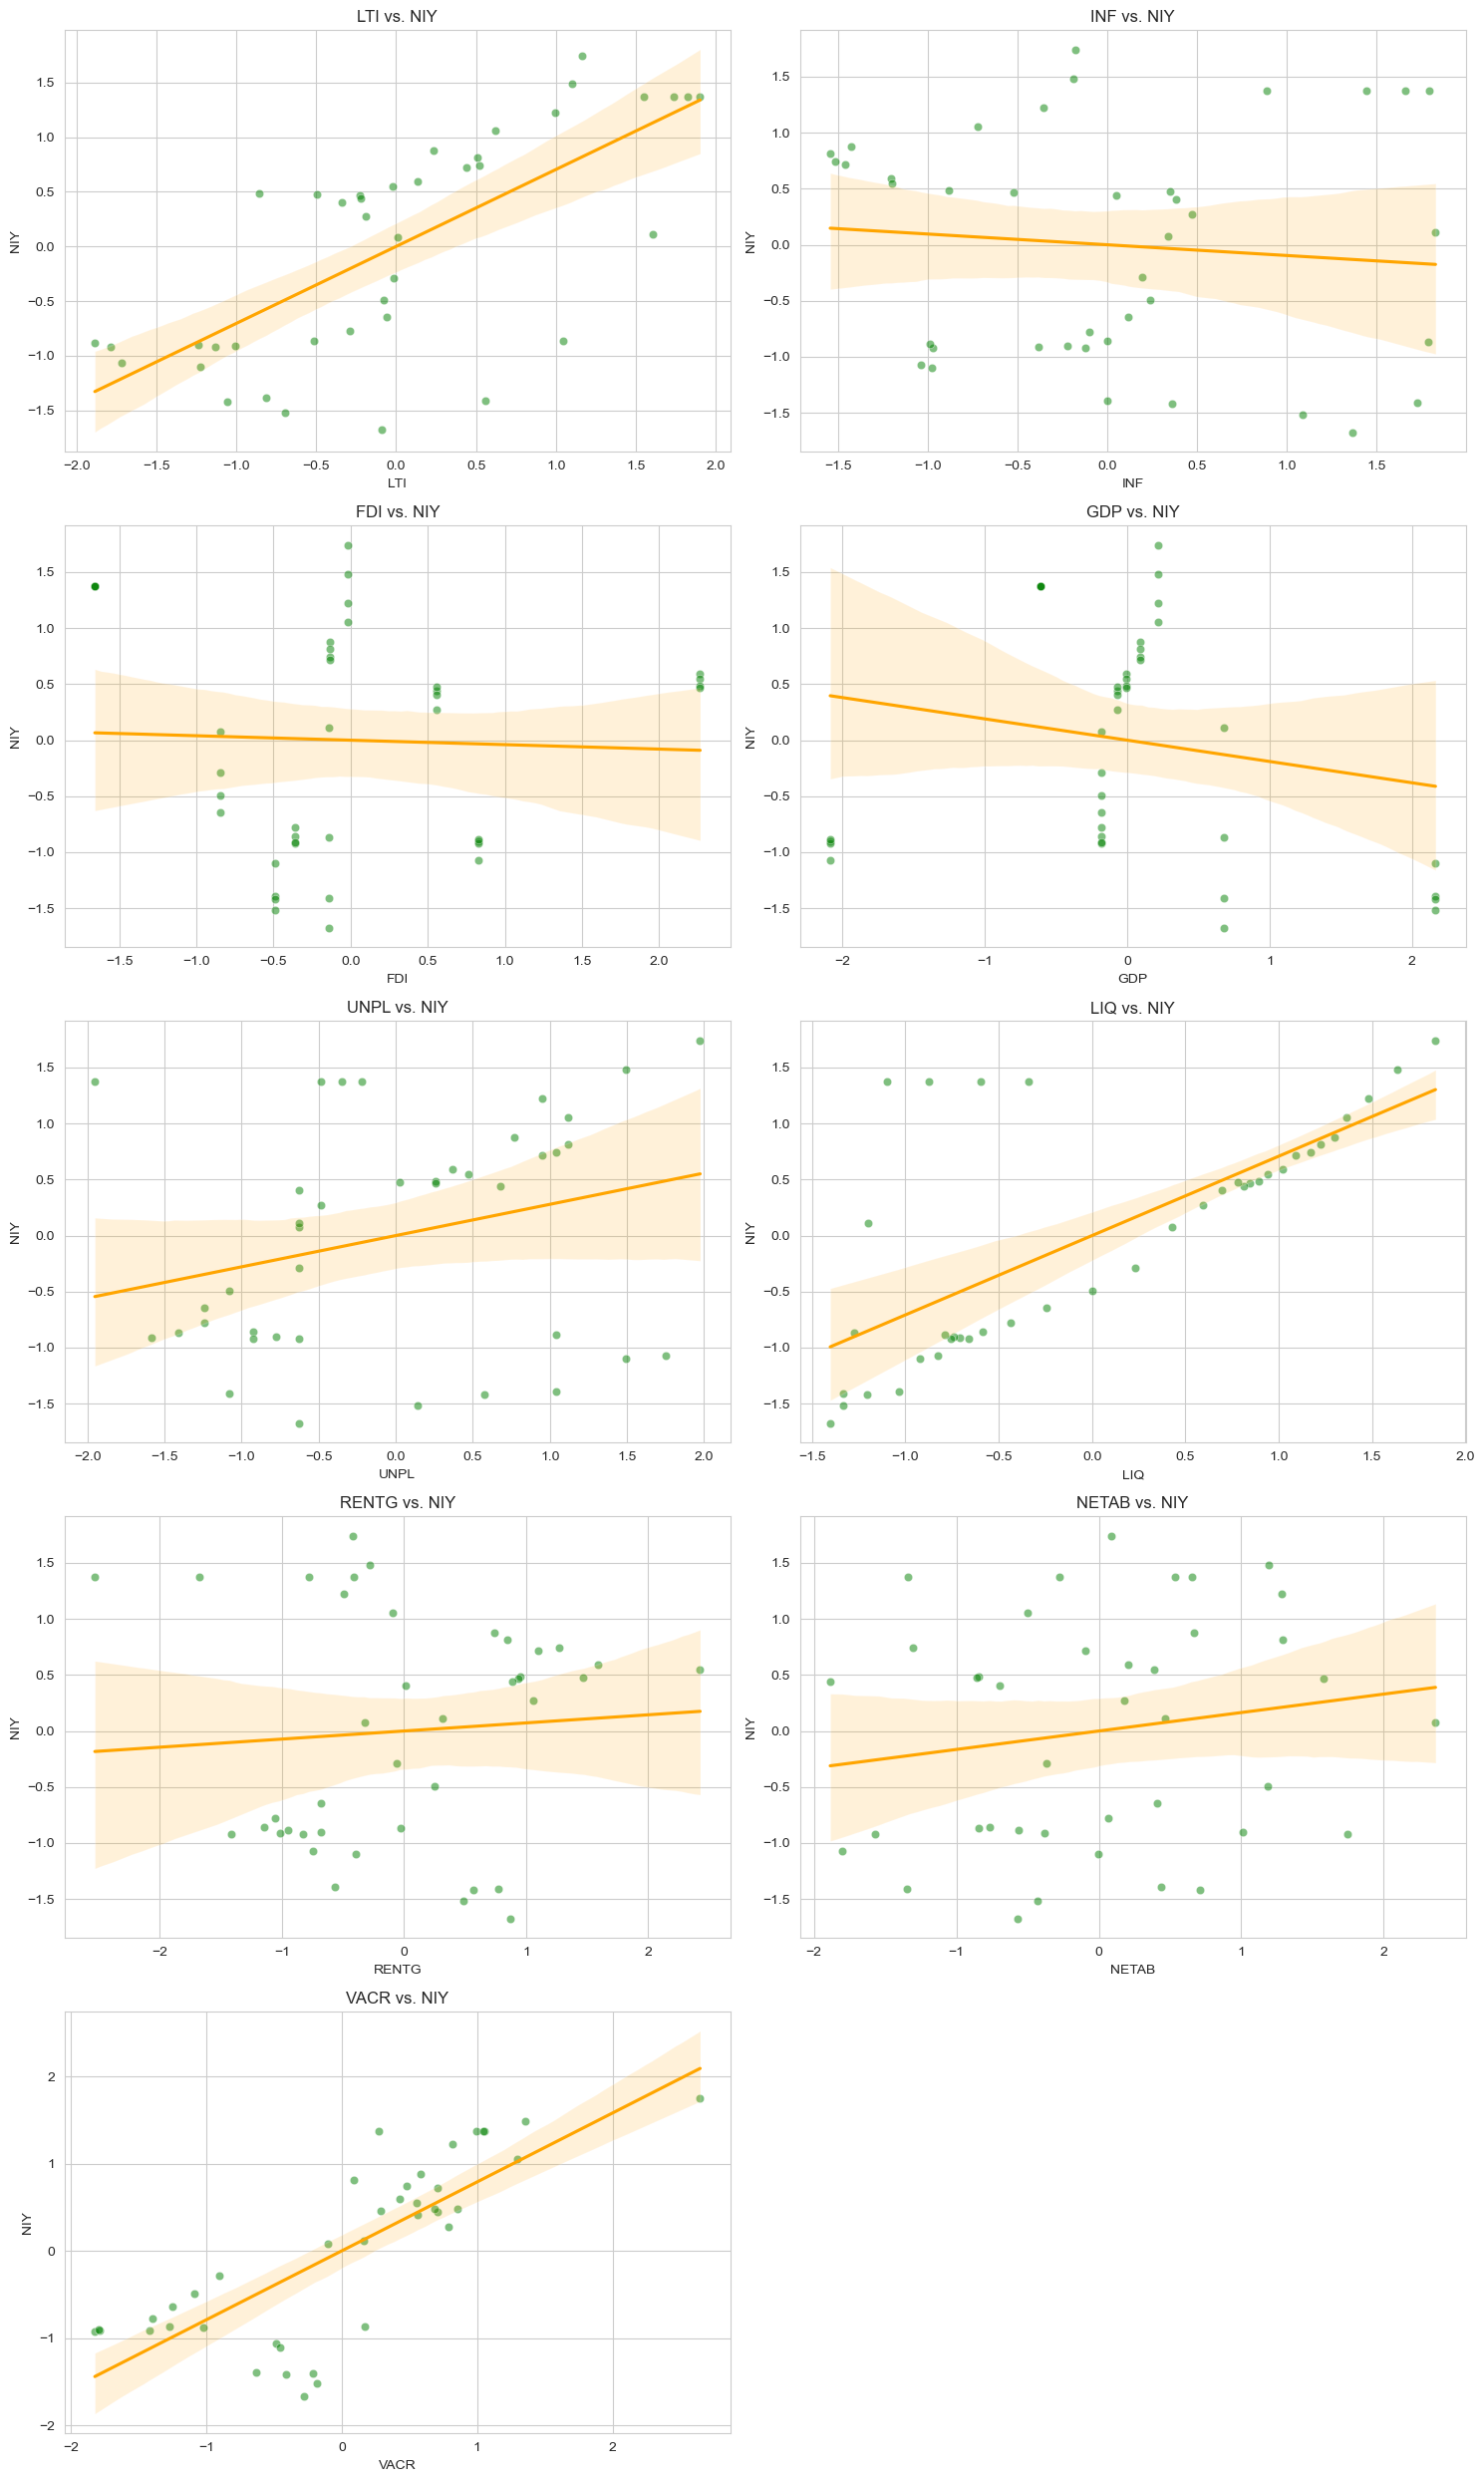

In [37]:
# visualise relationships with IVs and DV
iv_columns = [col for col in df_filtered.columns if col not in ['NIY', 'Date_Std', 'COVID_Dummy', 'Brexit_Dummy', 'FDI_Brexit', 'FDI_COVID', 'GDP_COVID']]
num_vars = len(iv_columns)
rows = math.ceil(num_vars / 2)  
fig, axes = plt.subplots(rows, 2, figsize=(15, 5 * rows)) 

axes = axes.flatten()

# plot against DV
for i, column in enumerate(iv_columns):
    sns.scatterplot(x=df_filtered[column], y=df_filtered['NIY'], ax=axes[i], color='green', alpha=0.5)
    
    # add line of best fit
    sns.regplot(x=df_filtered[column], y=df_filtered['NIY'], ax=axes[i], scatter=False, color='orange')
    
    axes[i].set_title(f'{column} vs. NIY')
    axes[i].set_xlabel(column)
    axes[i].set_ylabel('NIY')

# hide unused subplots
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

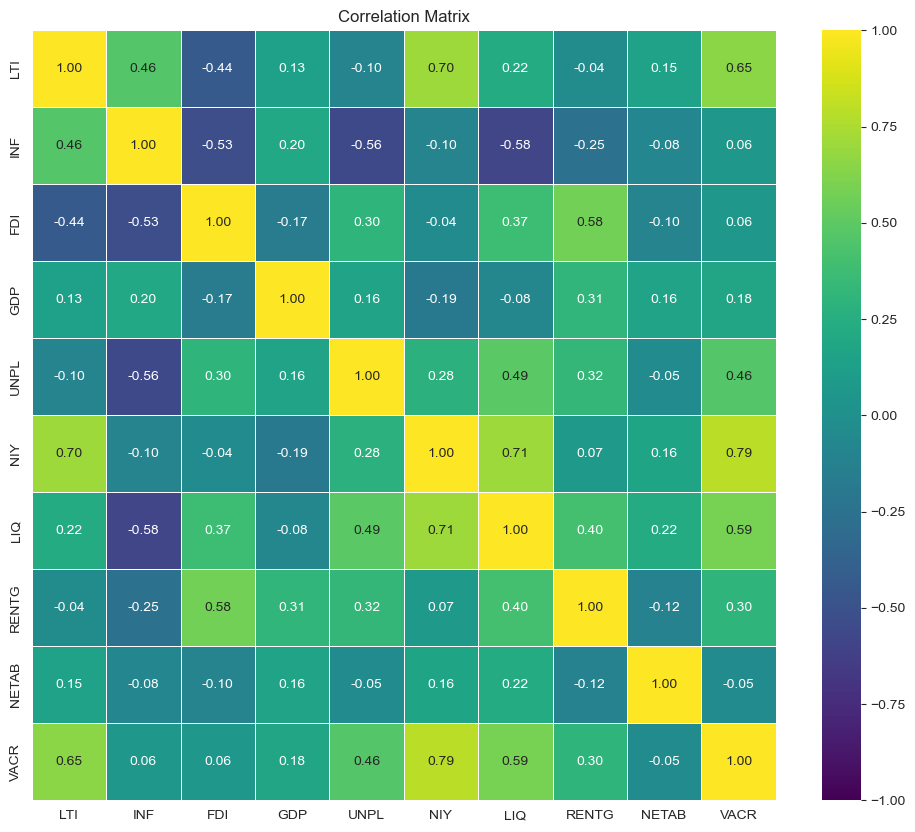

In [38]:
# correlation analysis with NIY
corr_matrix = df_filtered[numeric_cols].corr()
plt.figure(figsize=(12, 10))
sns.heatmap(corr_matrix, annot=True, cmap='viridis', vmin=-1, vmax=1, fmt='.2f', linewidths=.5)
plt.title('Correlation Matrix')
plt.show()

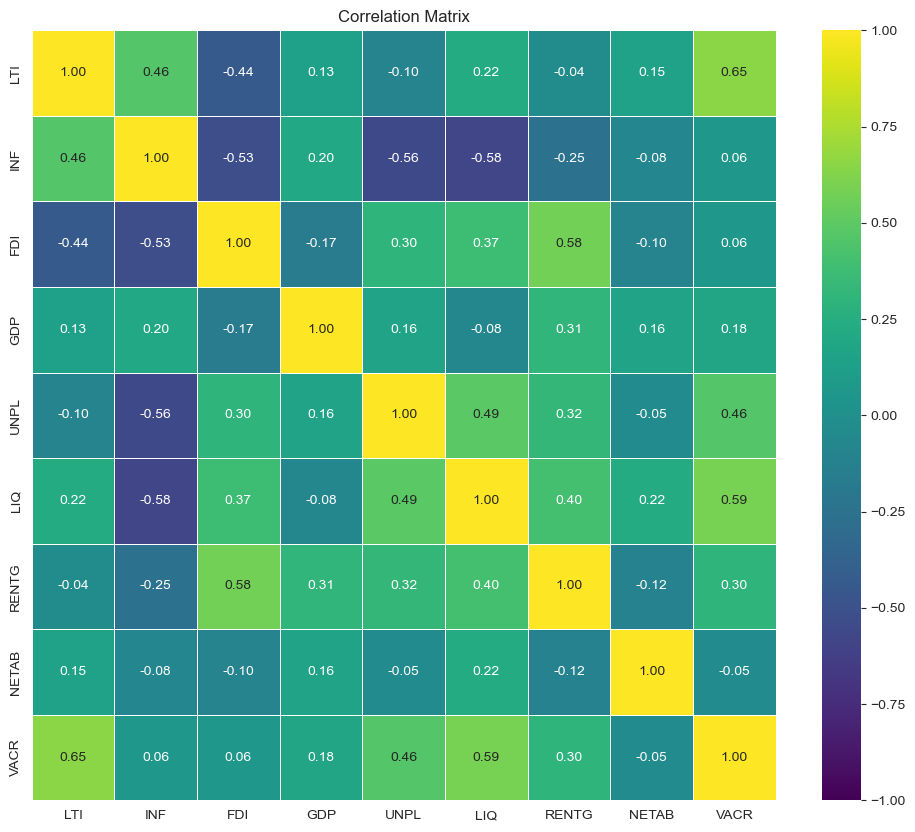

In [39]:
# relationship between IVs
corr_matrix = df_filtered[iv_columns].corr()
plt.figure(figsize=(12, 10))
sns.heatmap(corr_matrix, annot=True, cmap='viridis', vmin=-1, vmax=1, fmt='.2f', linewidths=.5)
plt.title('Correlation Matrix')
plt.show()

In [40]:
# check multicorr - VIF
X = df_filtered[iv_columns]
X_with_const = sm.add_constant(X)

vif_data = pd.DataFrame()
vif_data["Variable"] = X_with_const.columns
vif_data["VIF"] = [variance_inflation_factor(X_with_const.values, i) for i in range(X_with_const.shape[1])]

vif_data

,Variable,VIF
0,const,1.000000
1,LTI,4.862968
2,INF,5.823702
3,FDI,3.339938
4,GDP,1.843884
5,UNPL,3.439801
6,LIQ,5.948778
7,RENTG,2.636968
8,NETAB,1.570044
9,VACR,7.858017


# Model Selection and Estimation

## LASSO Regression

In [41]:
macro_vars = ['GDP', 'FDI', 'INF', 'UNPL', 'LIQ']
micro_vars = ['LTI', 'RENTG', 'NETAB', 'VACR']
dummies = ['Brexit_Dummy', 'COVID_Dummy']

In [42]:
# create interactions
interactions = []

for var in [v for v in macro_vars if v not in {'GDP', 'FDI'}]:
    for event in ['COVID', 'Brexit']:
        interaction_term = f'{var}_{event}'
        interactions.append(interaction_term)
        df_filtered[interaction_term] = df_filtered[var] * df_filtered[f'{event}_Dummy']

for var in micro_vars:
    for event in ['COVID', 'Brexit']:
        interaction_term = f'{var}_{event}'
        interactions.append(interaction_term)
        df_filtered[interaction_term] = df_filtered[var] * df_filtered[f'{event}_Dummy']
        

In [43]:
# from the literature
interaction_term = 'GDP_FDI'
if interaction_term not in interactions: 
    interactions.append(interaction_term)
    df_filtered[interaction_term] = df_filtered['GDP'] * df_filtered['FDI']

In [44]:
# check
# print(interactions)

#### Feature selection

In [45]:
# use PACF to find lag number
def determine_optimal_lags(series, max_lags=10):
    pacf_values = pacf(series, nlags=max_lags)
    optimal_lags = np.where(np.abs(pacf_values) > 1.96/np.sqrt(len(series)))[0]  # 95% CI
    return max(1, optimal_lags[-1])  # at least 1 lag

optimal_lags = determine_optimal_lags(df_filtered['NIY'])
print(f"Optimal lags for NIY: {optimal_lags}") 

Optimal lags for NIY: 5


In [46]:
# build lags using optimal_lags calculated above 
def build_lags(data, n_lags=optimal_lags):
    df = DataFrame(data)
    cols, names = list(), list()
    col_names = list(data)

    for i in range(n_lags, 0, -1):
        cols.append(df.shift(i))
        names += [('%s (t-%d)' % (j, i)) for j in col_names]
        
    cols.append(df.shift(-i))
    names += [('%s (t)' % (j)) for j in col_names]

    add = concat(cols, axis=1)
    add.columns = names
    add.dropna(inplace=True)
    
    return add

In [47]:
lag_data = build_lags(df_filtered[numeric_cols], n_lags=optimal_lags)

In [48]:
# create a list of all columns wanted
filtered_columns = dummies + interactions + ['GDP_COVID', 'FDI_COVID', 'FDI_Brexit']

# verify these columns exist in df_filtered
missing_cols = [col for col in filtered_columns if col not in df_filtered.columns]
if missing_cols:
    print(f"WARNING: These columns are missing from df_filtered: {missing_cols}")
    filtered_columns = [col for col in filtered_columns if col in df_filtered.columns]

# combine with lag_data columns
all_columns = lag_data.columns.tolist() + filtered_columns

# remove duplicates
seen = set()
unique_columns = [col for col in all_columns if not (col in seen or seen.add(col))]

# create new df by joining data
lag_data_combined = lag_data.join(df_filtered[filtered_columns], how='left')

# check
# print(lag_data_combined.head())
# print("Shape:", lag_data_combined.shape)

In [49]:
y = lag_data_combined[['NIY (t)']]
y.shape

(34, 1)

In [50]:
X = lag_data_combined.drop(columns=['NIY (t)']) 
X.shape

(34, 79)

In [51]:
# tscv split needed due to time series data - prevent data leakage
tscv = TimeSeriesSplit(n_splits=5, gap=0) 
splits = list(tscv.split(X, y))

In [52]:
# find best alpha (lambda)
    # note lambda is a reserved word in python so alpha is used to avoid overlap
model = Lasso()
grid = dict()
grid['alpha'] = arange(0, 1, 0.001)
search = GridSearchCV(model, grid, scoring='neg_mean_absolute_error', cv=tscv, verbose=0)
results = search.fit(X, y)

In [53]:
best_alpha = results.best_estimator_.alpha
best_score = results.best_score_

print(f"Best alpha: {best_alpha}")
print(f"Best Negative MAE score: {best_score}")

Best alpha: 0.001
Best Negative MAE score: -0.7672314903933308


In [54]:
alpha_values = grid['alpha'].tolist()
scores = -np.array(results.cv_results_['mean_test_score'].tolist())

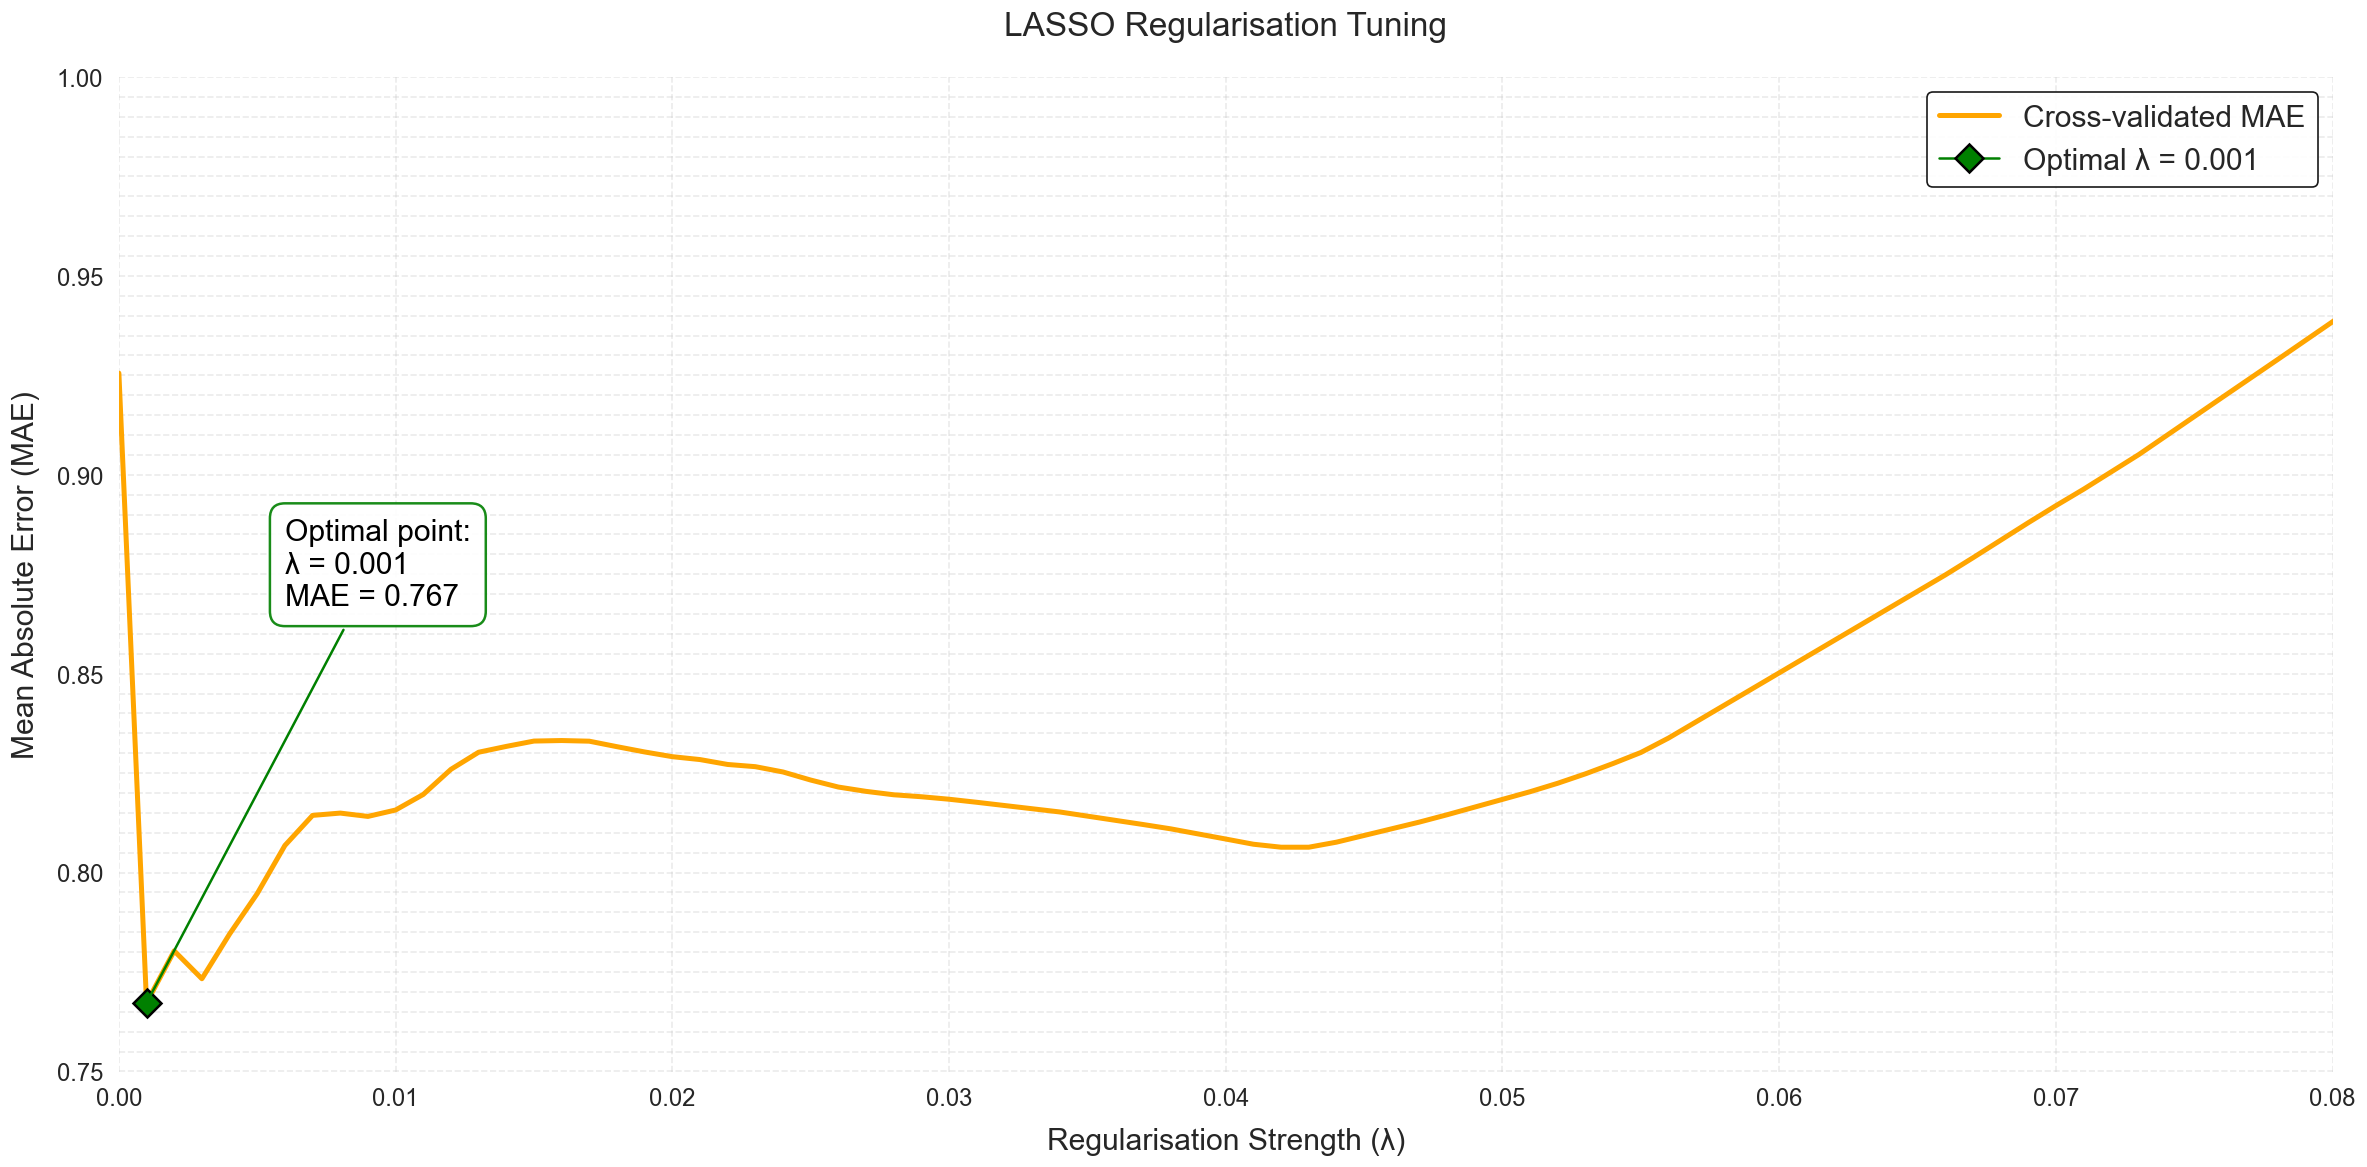

In [55]:
# plot MAE as alpha (regularisation strength) changes
sns.set(font_scale=1.3, rc={'figure.figsize': (20, 10), "figure.dpi": 120})
sns.set_style("whitegrid", {'grid.linestyle': '--', 'grid.alpha': 0.4})

# create MAE line
ax = sns.lineplot(
    x=alpha_values, 
    y=scores, 
    color='orange', 
    linewidth=3,
    label='Cross-validated MAE'
)

plt.xlim(0, 0.08)
plt.ylim(0.75, 1)

# highlight optimal alpha point
optimal_point = plt.plot(
    best_alpha, 
    -best_score, 
    marker="D", 
    color='green', 
    markersize=12,
    markeredgewidth=1.5,
    markeredgecolor='black',
    label=f'Optimal λ = {best_alpha:.3f}'
)

# annotate
annotation_text = f"Optimal point:\nλ = {best_alpha:.3f}\nMAE = {-best_score:.3f}"
plt.annotate(
    annotation_text,
    xy=(best_alpha, -best_score),
    xytext=(best_alpha + 0.005, -best_score + 0.1), 
    fontsize=18,
    color='black',
    bbox=dict(
        boxstyle='round,pad=0.5',
        fc='white',
        ec='green', 
        alpha=0.9,
        lw=1.5
    ),
    arrowprops=dict(
        arrowstyle='-',
        color='green',
        lw=1.5
    )
)

# titles
plt.title('LASSO Regularisation Tuning', 
          fontsize=20, pad=25)
plt.xlabel('Regularisation Strength (λ)', fontsize=18, labelpad=10)
plt.ylabel('Mean Absolute Error (MAE)', fontsize=18, labelpad=10)

plt.legend(
    loc='upper right',
    frameon=True,
    framealpha=0.9,
    edgecolor='black',
    fontsize=18
)

ax.grid(True, which='both', linestyle='--', alpha=0.4)
sns.despine(left=True, bottom=True) 

ax.xaxis.set_minor_locator(plt.MultipleLocator(0.01))
ax.yaxis.set_minor_locator(plt.MultipleLocator(0.005))

plt.tight_layout()
plt.show()

In [56]:
# set model to have the best alpha (lambda)
model = Lasso(alpha=best_alpha)

In [57]:
# dictionary to track how many times a feature appears
params = {p: 0 for p in X.columns}

# count feature selection across CV folds
for i, (train_idx, _) in enumerate(tscv.split(X)):
    X_train = X.iloc[train_idx]
    y_train = y.iloc[train_idx]
    
    model.fit(X_train, y_train)
    
    # update counts for non zero coefficients
    for feat, coef in zip(X.columns, model.coef_):
        if coef != 0:
            params[feat] += 1

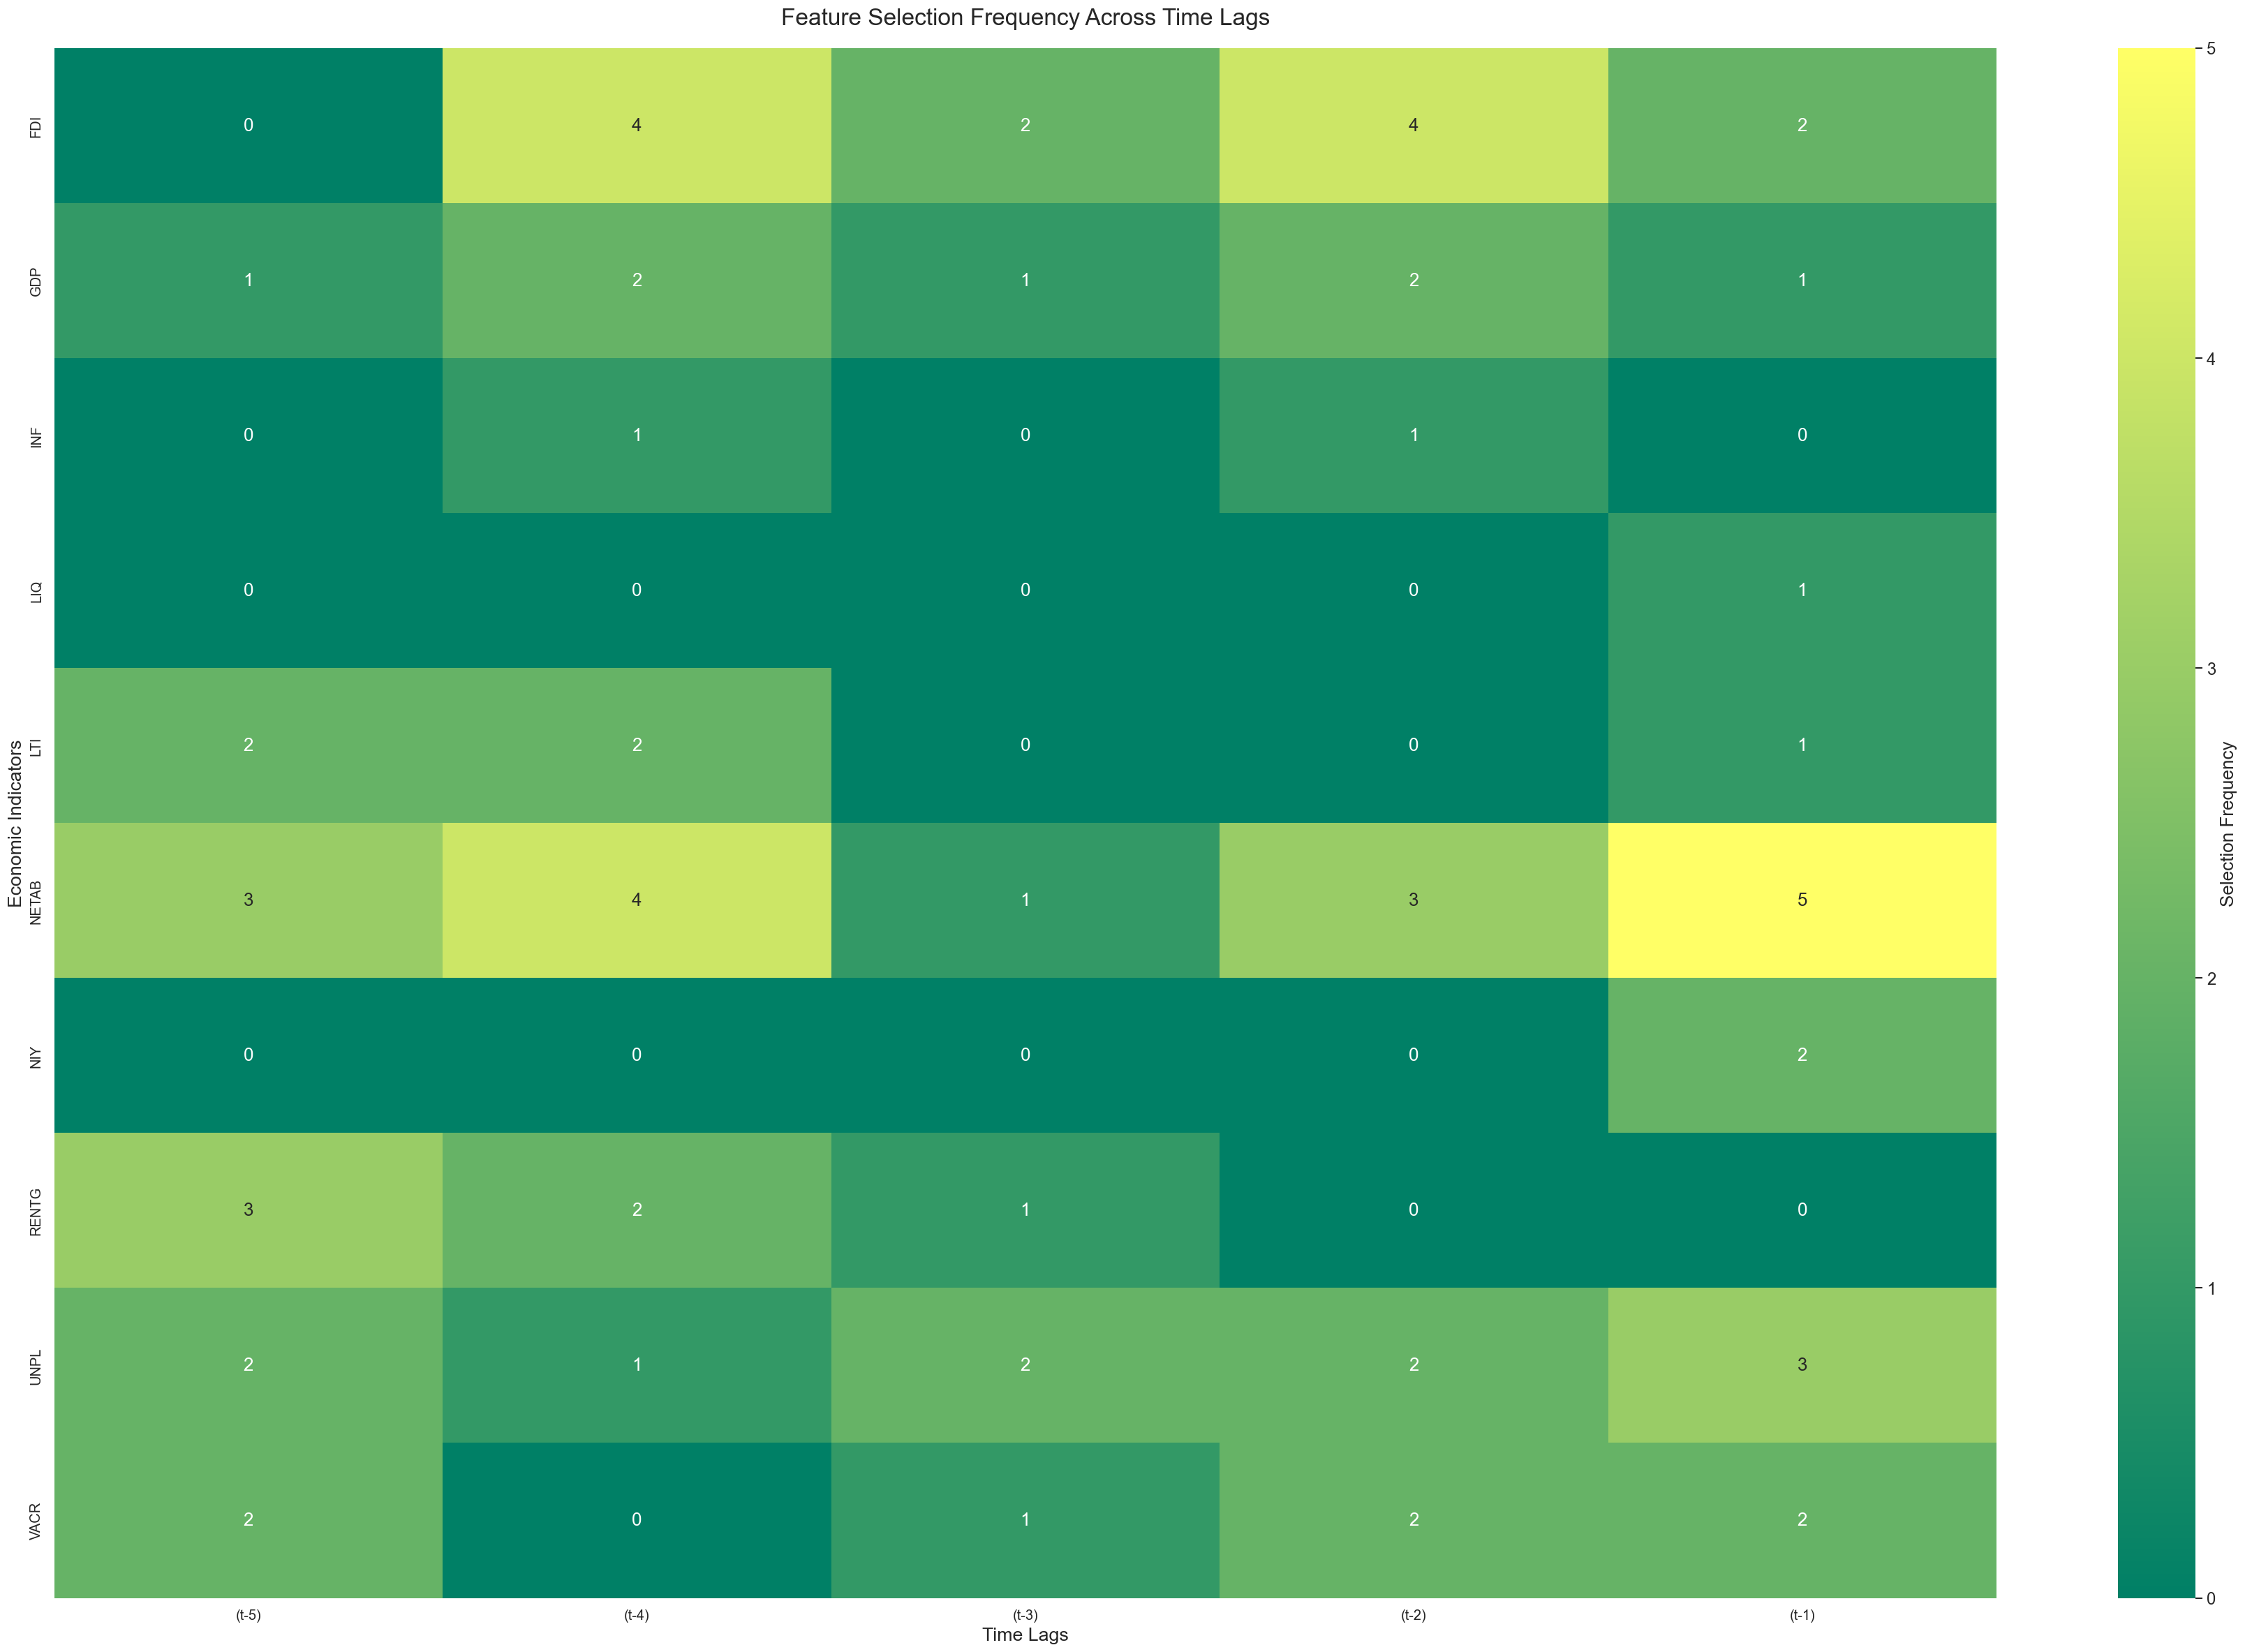

In [58]:
# create heatmap to track how many times a feature was selected across lags 
# get base column names
numerical_cols = sorted(list({
    col.split(' (t-')[0] 
    for col in X.columns 
    if ' (t-' in col
}))

# fill parameter matrix for the counts dictionary
optimal_lags = max(int(col.split('(t-')[1].replace(')','')) 
                  for col in X.columns if '(t-' in col)

param_matrix = np.zeros((len(numerical_cols), optimal_lags))
for i, col_base in enumerate(numerical_cols):
    for lag in range(1, optimal_lags + 1):
        col_name = f"{col_base} (t-{lag})"
        param_matrix[i, lag-1] = params.get(col_name, 0)

# create and plot heatmap
count_df = pd.DataFrame(
    param_matrix,
    index=numerical_cols,
    columns=[f'(t-{lag})' for lag in range(1, optimal_lags + 1)]
).iloc[:, ::-1] 

plt.figure(figsize=(30, 20))
sns.heatmap(
    count_df, 
    annot=True, 
    cmap='summer',
    fmt='g',
    cbar_kws={'label': 'Selection Frequency'}
)
plt.title('Feature Selection Frequency Across Time Lags', fontsize=20, pad=20)
plt.xlabel('Time Lags', fontsize=16)
plt.ylabel('Economic Indicators', fontsize=16)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.tight_layout()
plt.show()

#### Final Model

In [59]:
# create subset of features using threshold of over 50% (3/5 = 60%) appearance
threshold = tscv.n_splits * 0.6
selected_features = [feat for feat, count in params.items() if count >= threshold]

In [60]:
print(selected_features)

['RENTG (t-5)', 'NETAB (t-5)', 'FDI (t-4)', 'NETAB (t-4)', 'FDI (t-2)', 'NETAB (t-2)', 'UNPL (t-1)', 'NETAB (t-1)', 'FDI (t)', 'NETAB (t)', 'VACR (t)']


In [61]:
# check if important features were excluded (3/5 = threshold) - incl interactions
print("Top 15 most frequently selected features:")
print(pd.Series(params).sort_values(ascending=False).head(15))

Top 15 most frequently selected features:
NETAB (t-1)    5
FDI (t-4)      4
VACR (t)       4
NETAB (t-4)    4
NETAB (t)      4
FDI (t-2)      4
UNPL (t-1)     3
NETAB (t-5)    3
NETAB (t-2)    3
FDI (t)        3
RENTG (t-5)    3
LTI_Brexit     2
GDP (t-2)      2
UNPL (t-2)     2
FDI (t-1)      2
dtype: int64


In [62]:
X_final = X[selected_features].copy()

In [63]:
train_size = int(0.8 * len(X_final))
X_train, X_test = X_final.iloc[:train_size], X_final.iloc[train_size:]
y_train, y_test = y.iloc[:train_size], y.iloc[train_size:]

In [64]:
# fit model
final_model = Lasso(alpha=best_alpha, max_iter=10000)
final_model.fit(X_train, y_train)

Lasso(alpha=0.001, max_iter=10000)

In [65]:
def calculate_metrics(true_transformed, pred_transformed, y_transformer=None):
    """_summary_: calc performance metrics and inverse transform (optional)

    Args:
        true_transformed (df): real values (ground truth)
        pred_transformed (_type_): predicted values
        y_transformer (_type_, optional): fitted PowerTransformer. Defaults to None.

    Returns:
        Dict: metrics 
    """
    true = np.array(true_transformed).reshape(-1, 1)
    pred = np.array(pred_transformed).reshape(-1, 1)

    if y_transformer is not None:
        true = y_transformer.inverse_transform(true).flatten()
        pred = y_transformer.inverse_transform(pred).flatten()
    else:
        true = true.flatten()
        pred = pred.flatten()
    
    with np.errstate(divide='ignore', invalid='ignore'):
        abs_error = np.abs(true - pred)
        mape = np.nanmean(abs_error / np.abs(true)) * 100 
    
    return {
        'RMSE': np.sqrt(mean_squared_error(true, pred)),
        'MAE': mean_absolute_error(true, pred),
        'R2': r2_score(true, pred),
        'MAPE': mape
    }

In [66]:
# check accuracy 
print("All metrics in original NIY units")

y_train_pred = final_model.predict(X_train)
train_metrics = calculate_metrics(y_train, y_train_pred, y_transformer=y_transformer)

print("\nTraining Performance:")
for m, v in train_metrics.items():
    print(f"{m}: {v:.4f}")

y_test_pred = final_model.predict(X_test)
test_metrics = calculate_metrics(y_test, y_test_pred, y_transformer=y_transformer)

print("\nTest Performance:")
for m, v in test_metrics.items():
    print(f"{m}: {v:.4f}")

All metrics in original NIY units

Training Performance:
RMSE: 0.0020
MAE: 0.0017
R2: 0.8162
MAPE: 4.0643

Test Performance:
RMSE: 0.0043
MAE: 0.0040
R2: 0.6041
MAPE: 8.6090


# Bootstrap

In [67]:
# confirm that X has all columns 
print(X.shape)

(34, 79)


In [68]:
# run bootstrap
def bootstrap_lasso(X, y, n_bootstraps=1000, alpha=best_alpha):
    feature_names = X.columns
    selection_counts = {f: 0 for f in feature_names}
    coef_paths = []
    
    for _ in range(n_bootstraps):
        X_resampled, y_resampled = resample(X, y)
        model = Lasso(alpha=alpha, max_iter=10000)
        model.fit(X_resampled, y_resampled)
        
        selected_mask = model.coef_ != 0
        for idx, f in enumerate(feature_names):
            if selected_mask[idx]:
                selection_counts[f] += 1
                
        coef_paths.append(model.coef_)
    
    selection_probs = {k: v/n_bootstraps for k, v in selection_counts.items()}
    stability_paths = pd.DataFrame(coef_paths, columns=feature_names)
    
    return selection_probs, stability_paths

selection_probs, stability_paths = bootstrap_lasso(X_train, y_train, n_bootstraps=1000, alpha=best_alpha)

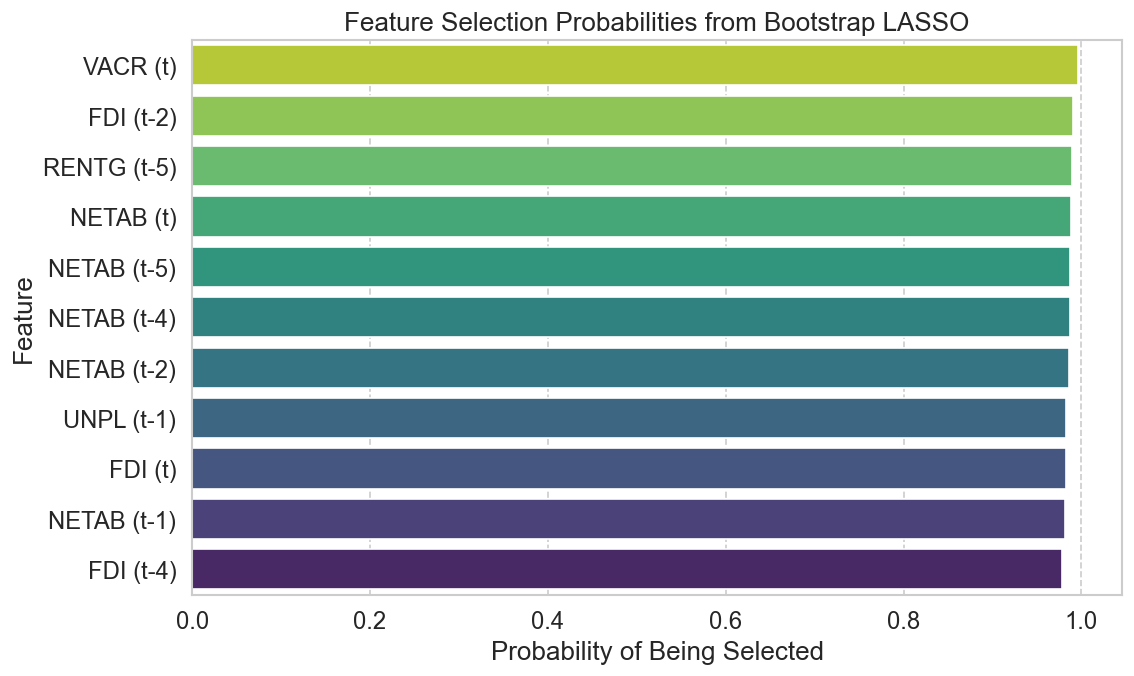

In [69]:
# plot
prob_df = pd.DataFrame.from_dict(selection_probs, orient='index', columns=['Selection Probability'])
prob_df = prob_df.sort_values(by='Selection Probability', ascending=False)

plt.figure(figsize=(10, 6))
sns.barplot(x=prob_df['Selection Probability'], y=prob_df.index, palette='viridis_r')
plt.title("Feature Selection Probabilities from Bootstrap LASSO")
plt.xlabel("Probability of Being Selected")
plt.ylabel("Feature")
plt.show()

In [70]:
# get stable predictors that meet >= 90% threshold
significant_features = [f for f, prob in selection_probs.items() if prob >= 0.9]
print(f"Stable predictors:")
for i in significant_features:
    print(i)

Stable predictors:
RENTG (t-5)
NETAB (t-5)
FDI (t-4)
NETAB (t-4)
FDI (t-2)
NETAB (t-2)
UNPL (t-1)
NETAB (t-1)
FDI (t)
NETAB (t)
VACR (t)


In [71]:
# check what features are across both original LASSO and bootstrap
set_original = set(selected_features)
set_bootstrap = set(significant_features)

# in original but NOT in bootstrap
only_in_original = set_original - set_bootstrap
print(f"Features unique to original LASSO: {only_in_original}")

# in bootstrap but NOT in original
only_in_bootstrap = set_bootstrap - set_original
print(f"Features unique to bootstrap: {only_in_bootstrap}")

# all non-overlapping features
non_overlapping = set_original.symmetric_difference(set_bootstrap)
print(f"All non-overlapping features: {non_overlapping}")

Features unique to original LASSO: set()
Features unique to bootstrap: set()
All non-overlapping features: set()


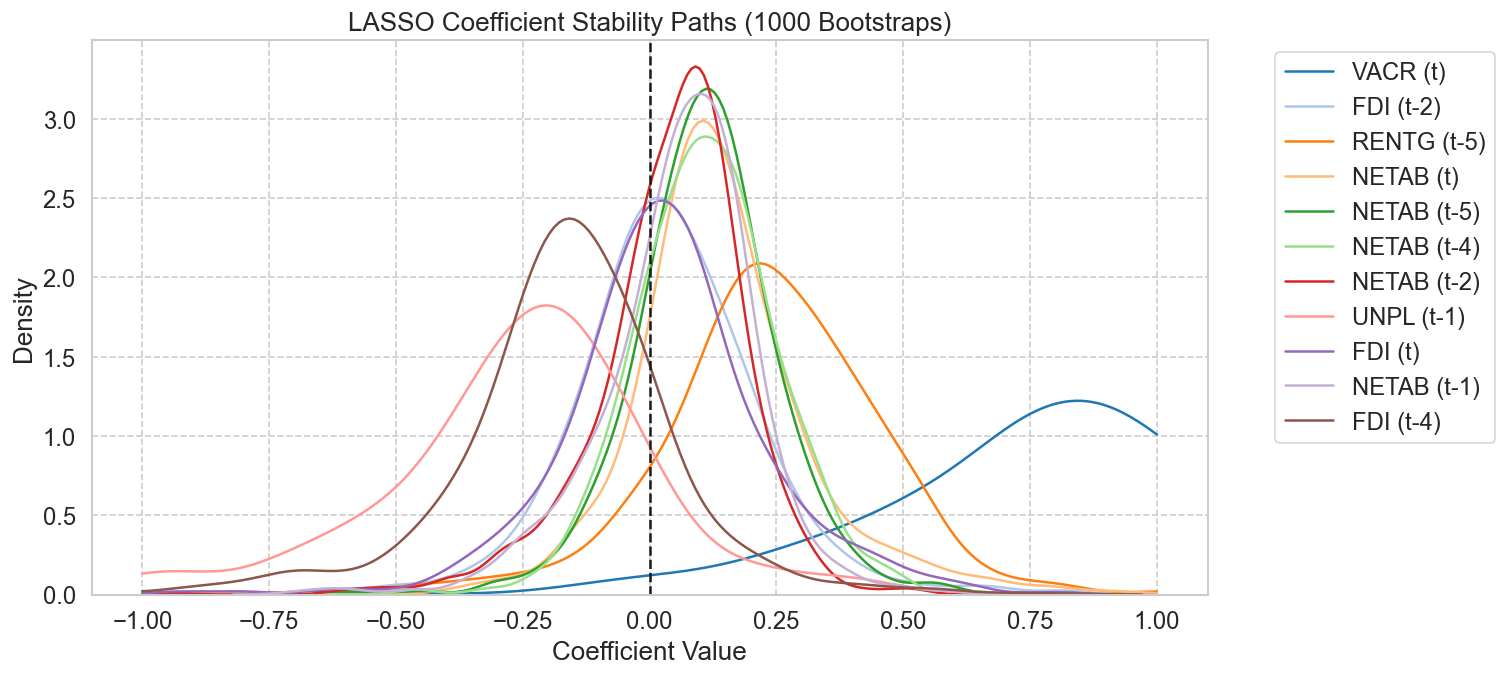

In [72]:
# plot stability paths - coefficient dist.
plt.figure(figsize=(12, 6))
colours = sns.color_palette("tab20", n_colors=11)
for i, feature in enumerate(prob_df.index[:11]):  # most frequent features = 11 features
    sns.kdeplot(stability_paths[feature], label=feature, clip=(-1,1), color=colours[i])
plt.axvline(0, color='k', linestyle='--')
plt.title("LASSO Coefficient Stability Paths (1000 Bootstraps)")
plt.xlabel("Coefficient Value")
plt.ylabel("Density")
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()

In [73]:
# selection probabilities with bootstrap LASSO
print(prob_df.to_string(float_format="%.3f"))

             Selection Probability
VACR (t)            0.996         
FDI (t-2)           0.990         
RENTG (t-5)         0.989         
NETAB (t)           0.988         
NETAB (t-5)         0.987         
NETAB (t-4)         0.987         
NETAB (t-2)         0.986         
UNPL (t-1)          0.983         
FDI (t)             0.983         
NETAB (t-1)         0.982         
FDI (t-4)           0.978         


# Forecasting

In [74]:
# forecast using the selected variables from LASSO
selected_features = [
    'RENTG (t-5)', 'NETAB (t-5)', 'FDI (t-4)', 'NETAB (t-4)', 
    'FDI (t-2)', 'NETAB (t-2)', 'UNPL (t-1)', 'NETAB (t-1)', 
    'FDI (t)', 'NETAB (t)', 'VACR (t)'
]

# convert to base variables (no lags)
required_vars = sorted(list({col.split(' (t-')[0].split(' (t)')[0] for col in selected_features}))
print("Base variables needed:", required_vars)

Base variables needed: ['FDI', 'NETAB', 'RENTG', 'UNPL', 'VACR']


### Data Preparation

In [75]:
# obtain data that exists 2014-01-01 to 2029-01-01
start_date = '2014-01-01'
end_date = '2029-01-01'

# filter the data based on 'Date_Std'
df_future = df_final[
    (df_final['Date_Std'] >= start_date) & (df_final['Date_Std'] <= end_date)
]

vars_date = list(set(required_vars + ['Date_Std']))
df_future = df_future[vars_date]
df_future = df_future.set_index('Date_Std').sort_index()
df_future = df_future[~df_future.index.duplicated(keep='last')]
# check
# df_future  # in full 
df_future.head()  # for less output

,RENTG,UNPL,VACR,FDI,NETAB
Date_Std,,,,,
2014-01-01,0.017439,7.800000,0.055000,"58,890,445,252.713997","-109,398.000000"
2014-04-01,0.017821,7.000000,0.047668,"58,890,445,252.713997","548,510.000000"
2014-07-01,0.017231,6.300000,0.044221,"58,890,445,252.713997","605,480.000000"
2014-10-01,0.018350,6.500000,0.047286,"58,890,445,252.713997","-399,689.000000"
2015-01-01,0.020555,6.100000,0.042665,"45,333,483,122.089897","220,258.000000"


In [76]:
# scaling (needed for LASSO) on historical data
train_end = '2023-10-01'
scaler = PowerTransformer(method='yeo-johnson').fit(df_future.loc[:train_end].dropna())
imputer = IterativeImputer().fit(scaler.transform(df_future.loc[:train_end]))

df_scaled = pd.DataFrame(
    scaler.transform(df_future),
    columns=df_future.columns,
    index=df_future.index
)

In [77]:
# check
df_scaled.head()

,RENTG,UNPL,VACR,FDI,NETAB
Date_Std,,,,,
2014-01-01,-0.416522,1.962333,2.647449,-0.019446,0.088545
2014-04-01,-0.280765,1.480811,1.358522,-0.019446,1.194647
2014-07-01,-0.489687,0.948196,0.816671,-0.019446,1.286074
2014-10-01,-0.090159,1.113136,1.296553,-0.019446,-0.497816
2015-01-01,0.738753,0.771516,0.584527,-0.137030,0.665786


In [78]:
df_scaled.tail()  # check what is missing

,RENTG,UNPL,VACR,FDI,NETAB
Date_Std,,,,,
2028-01-01,-2.361041,NaN,2.781462,NaN,0.289115
2028-04-01,-2.419846,NaN,2.747300,NaN,0.120255
2028-07-01,-2.480610,NaN,2.721528,NaN,0.090754
2028-10-01,-2.507891,NaN,2.691641,NaN,0.134270
2029-01-01,-2.565738,NaN,2.639450,NaN,0.223179


In [79]:
# impute
imputer = IterativeImputer(
    estimator=RandomForestRegressor(),
    max_iter=50,
    random_state=42
)

df_imputed = pd.DataFrame(
    imputer.fit_transform(df_scaled[required_vars]),
    columns=required_vars,
    index=df_scaled.index
)

In [80]:
# check
# df_imputed   # full
df_imputed.tail()  # less output for readability

,FDI,NETAB,RENTG,UNPL,VACR
Date_Std,,,,,
2028-01-01,-1.486342,0.289115,-2.361041,-0.658182,2.781462
2028-04-01,-1.486342,0.120255,-2.419846,-0.603236,2.747300
2028-07-01,-1.486342,0.090754,-2.480610,-0.581504,2.721528
2028-10-01,-1.486342,0.134270,-2.507891,-0.603236,2.691641
2029-01-01,-1.478216,0.223179,-2.565738,-0.783640,2.639450


In [81]:
# function to generate NIY forecasting
def generate_forecasts(historical_data, future_data, model, selected_features, lags=optimal_lags):
    """_summary_: generate forecasts for NIY 
    Args:
        historical_data (df): DF up to current period
        future_data (df): DF with future feature values 
        model (Lasso Model): final trained Lasso
        selected_features (list): features from final model 
        lags (_type_, optional): _description_. Defaults to optimal_lags.

    Returns:
        series: NIY forecasts 2024-01-01 to 2029-01-01
    """
    forecasts = []
    combined_data = historical_data.copy()
    
    for i in range(len(future_data)):
        # update with newest available data
        current_date = future_data.index[i]
        combined_data.loc[current_date] = future_data.loc[current_date]
        
        # feature vector
        X_new = pd.DataFrame(index=[current_date])
        for feat in selected_features:
            if ' (t-' in feat:  # lagged feature (at t-N)
                var, lag = feat.split(' (t-')
                lag = int(lag.replace(')', ''))
                X_new[feat] = combined_data[var].shift(lag).loc[current_date]
            else:  # non-lagged features (at t)
                var = feat.replace(' (t)', '')
                X_new[feat] = combined_data[var].loc[current_date]
        
        # predict
        pred = model.predict(X_new)[0]
        forecasts.append(pred)
        
        # update NIY in history 
        combined_data.loc[current_date, 'NIY'] = pred
    
    return pd.Series(forecasts, index=future_data.index)

In [82]:
# call func
historical_data = df_scaled.loc[:'2023-10-01']  # last available data
future_data = df_imputed.loc['2024-01-01':]    # future periods (forecasted from)

# create forecasts
niy_forecasts = generate_forecasts(
    historical_data=historical_data,
    future_data=future_data[required_vars],
    model=final_model,
    selected_features=selected_features
)

In [83]:
# print forecast output to check
niy_forecasts

Date_Std
2024-01-01   1.874802
2024-04-01   1.935123
2024-07-01   2.499715
2024-10-01   2.380735
2025-01-01   3.408572
2025-04-01   5.140821
2025-07-01   4.666086
2025-10-01   4.516573
2026-01-01   4.100222
2026-04-01   3.714002
2026-07-01   3.196836
2026-10-01   2.847858
2027-01-01   2.533010
2027-04-01   2.349574
2027-07-01   2.261370
2027-10-01   2.159160
2028-01-01   2.112200
2028-04-01   2.067895
2028-07-01   2.016863
2028-10-01   1.958834
2029-01-01   1.901863
dtype: float64

In [84]:
# backtesting to eval forecasting model 
def backtest_forecast_function(df, target_col='NIY', model=final_model, selected_features=selected_features, initial_train_size=20, test_size=1):
    """_summary_:test generate_forecast() with backtesting
    
    Args:
        df: DF with features and target
        model: final LASSO model
        selected_features: features used in forecasts
        initial_train_size: minimum training periods (20 quarters = 5 years).
        test_size: how far forward to forecast
    
    Returns:
        DF with true v predicted values
    """
    forecasts = []
    true_values = []
    dates = []
    
    for i in range(initial_train_size, len(df) - test_size + 1, test_size):
        historical = df.iloc[:i].copy()  # training data
        future = df.iloc[i:i + test_size].copy() # test data

        preds = generate_forecasts(
            historical_data=historical,
            future_data=future.drop(columns=[target_col]),
            model=model,
            selected_features=selected_features
        )
        
        forecasts.extend(preds)
        true_values.extend(future[target_col].values)
        dates.extend(future.index)
    
    return pd.DataFrame({'Date': dates, 'True': true_values, 'Predicted': forecasts})

In [85]:
# call func
backtest_data = df_scaled.copy()
backtest_data = backtest_data.loc[df_filtered['Date_Std']] 
backtest_data['NIY'] = df_filtered['NIY'].values 

backtest_results = backtest_forecast_function(
    df=backtest_data,
    initial_train_size=20,  
    test_size=1        
)

In [86]:
# print metrics 
metrics = calculate_metrics(
    true_transformed=backtest_results['True'],
    pred_transformed=backtest_results['Predicted'],
    y_transformer=y_transformer 
)

print("\nBacktest Metrics (Original NIY Units):")
for m, v in metrics.items():
    print(f"{m}: {v:.4f}")


Backtest Metrics (Original NIY Units):
RMSE: 0.0037
MAE: 0.0029
R2: 0.6605
MAPE: 7.0373


In [87]:
print("First 5 True values:\n", backtest_results['True'].head())
print("------------")
print("First 5 Predicted:\n", backtest_results['Predicted'].head())
print("------------")
print("Transformer fitted:", hasattr(y_transformer, 'lambdas_'))

First 5 True values:
 0   -0.774395
1   -0.862073
2   -0.919259
3   -0.911964
4   -0.902231
Name: True, dtype: float32
------------
First 5 Predicted:
 0   -0.206738
1   -0.672803
2   -1.043782
3   -0.950211
4   -1.027209
Name: Predicted, dtype: float64
------------
Transformer fitted: True


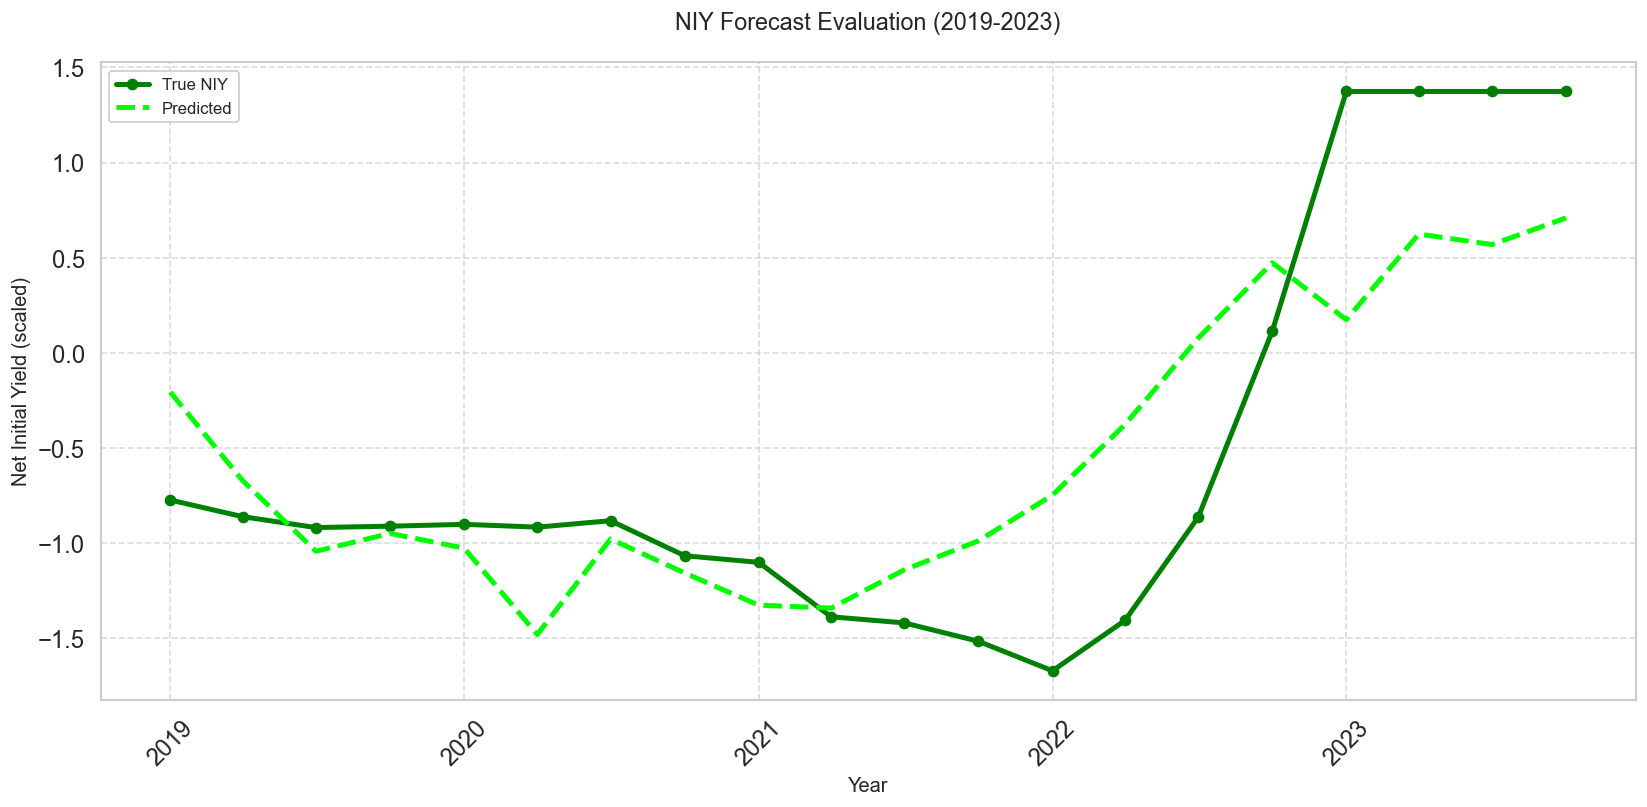

In [88]:
# plot true v predicted 
plt.figure(figsize=(14, 7))
sns.set_style("whitegrid")
plt.plot(backtest_results['Date'], backtest_results['True'], 
         label='True NIY', color='green', linewidth=3, marker='o', markersize=6)
plt.plot(backtest_results['Date'], backtest_results['Predicted'], 
         label='Predicted', linestyle='--', color='lime', linewidth=3)


# from 2019 because need 5 yers historic data for lags (this is 2014 data)
plt.title(f"NIY Forecast Evaluation (2019-2023)", 
          fontsize=14, pad=20)
plt.xlabel("Year", fontsize=12)
plt.ylabel("Net Initial Yield (scaled)", fontsize=12)
plt.legend(fontsize=10, framealpha=1)
plt.grid(True, linestyle='--', alpha=0.7)

plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

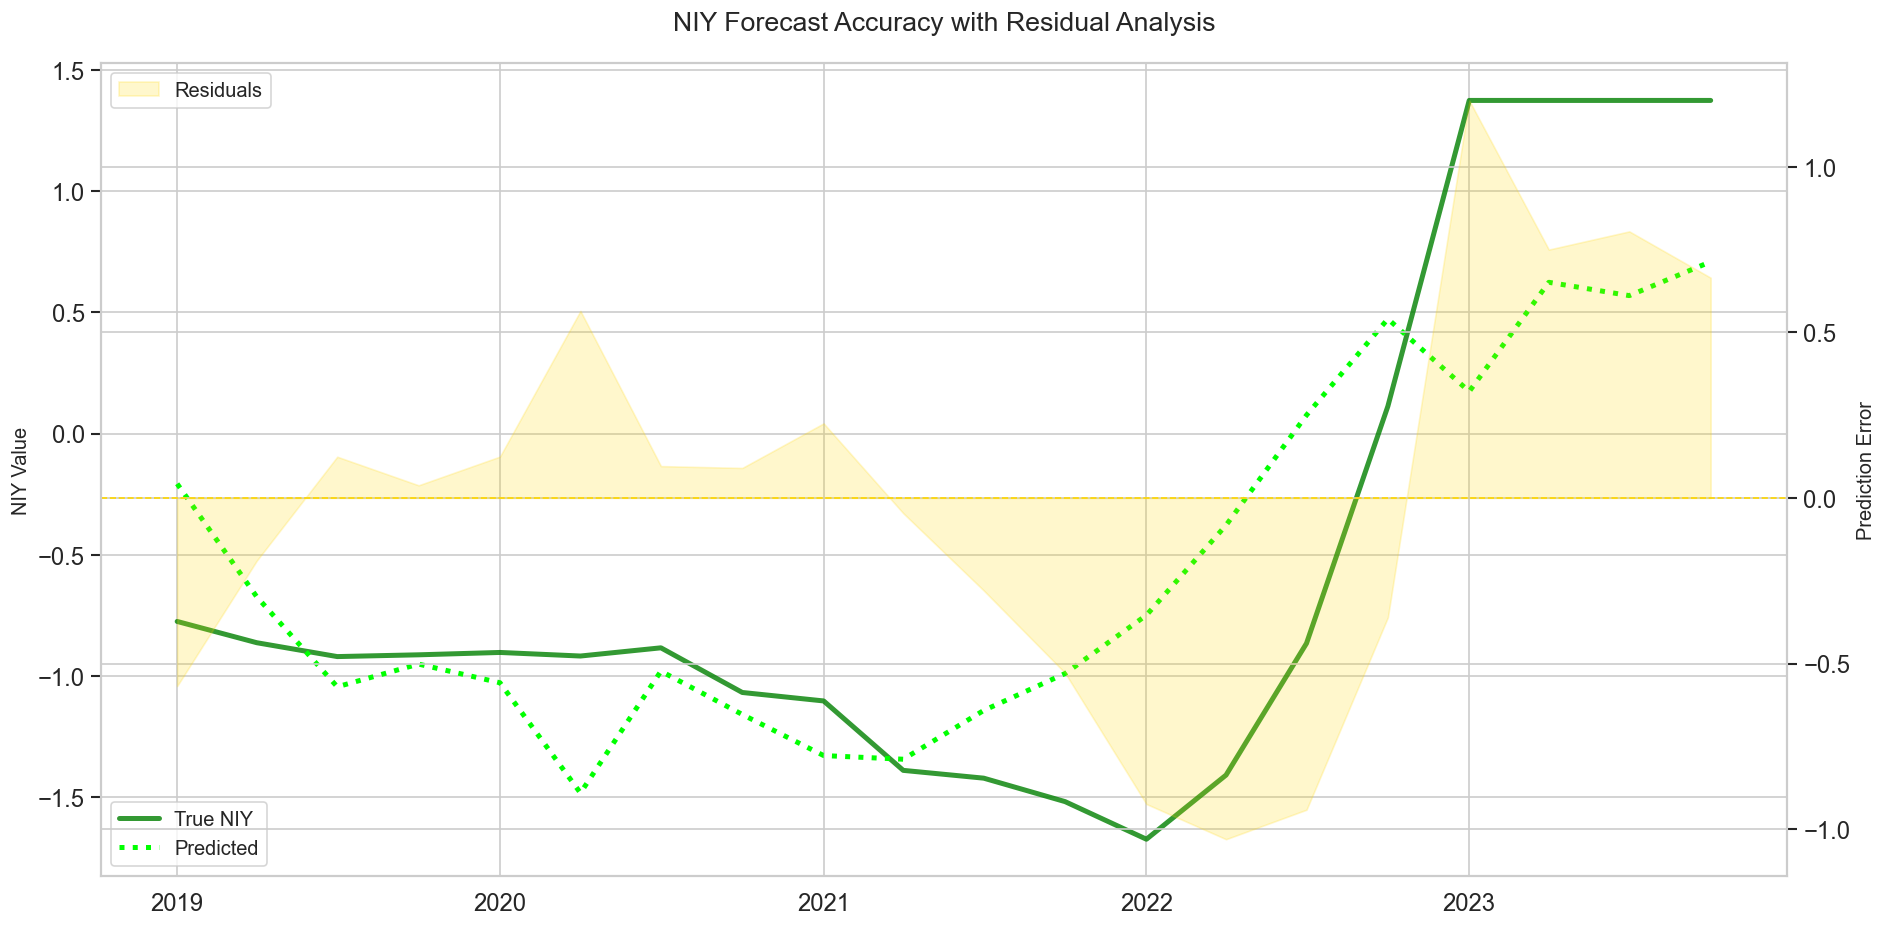

In [89]:
plt.figure(figsize=(16, 8))

# first axis - NIY true
ax1 = plt.gca()
ax1.plot(backtest_results['Date'], backtest_results['True'], 
         label='True NIY', color='green', linewidth=3, alpha=0.8)
ax1.plot(backtest_results['Date'], backtest_results['Predicted'], 
         label='Predicted', linestyle=':', color='lime', linewidth=3)
ax1.set_ylabel("NIY Value", fontsize=12)
ax1.legend(loc='lower left', fontsize=12)

# second axis - predicted residuals 
ax2 = ax1.twinx()
residuals = backtest_results['True'] - backtest_results['Predicted']
ax2.fill_between(backtest_results['Date'], residuals, 
                 color='gold', alpha=0.2, label='Residuals')
ax2.axhline(0, color='gold', linestyle='--', linewidth=1)
ax2.set_ylabel("Prediction Error", fontsize=12)
ax2.legend(loc='upper left', fontsize=12)

plt.title("NIY Forecast Accuracy with Residual Analysis", fontsize=16, pad=20)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()